In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


# Scikit-learn Modules for Feature Selection, Modeling, and Evaluation
from sklearn.model_selection import LeaveOneGroupOut, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance

# XGBoost for Gradient Boosted Models
from xgboost import XGBClassifier

# TensorFlow / Keras for LSTM and Deep Learning Models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Optional: Cycle module for ROC plotting
from itertools import cycle

In [ ]:
# Base path to your dataset
base_path = os.path.join("data", "UCI")

# STEP 1: Load and clean feature names
features = pd.read_csv(
    os.path.join(base_path, "features.txt"),
    sep="\s+", header=None, names=["index", "feature_name"]
)

# Force unique column names by appending an index if duplicate exists

feature_count = defaultdict(int)
unique_feature_names = []

for name in features["feature_name"]:
    name = name.strip()
    feature_count[name] += 1
    if feature_count[name] == 1:
        unique_feature_names.append(name)
    else:
        unique_feature_names.append(f"{name}_{feature_count[name]}")

# STEP 2: Load activity labels
activity_labels = pd.read_csv(
    os.path.join(base_path, "activity_labels.txt"),
    sep="\s+", header=None, names=["id", "activity"]
)
activity_map = dict(zip(activity_labels["id"], activity_labels["activity"]))

# STEP 3: Load training data
X_train = pd.read_csv(
    os.path.join(base_path, "train", "X_train.txt"),
    sep="\s+", header=None, names=unique_feature_names
)

y_train = pd.read_csv(
    os.path.join(base_path, "train", "y_train.txt"),
    header=None, names=["Activity"]
)

subject_train = pd.read_csv(
    os.path.join(base_path, "train", "subject_train.txt"),
    header=None, names=["Subject"]
)

# STEP 4: Combine into one DataFrame
train_df = pd.concat([subject_train, y_train, X_train], axis=1)
train_df["ActivityName"] = train_df["Activity"].map(activity_map)

# STEP 5: Preview
print("✅ Data imported successfully!")
print("📐 Shape of training data:", train_df.shape)
print("🎯 Sample activity labels:", train_df['ActivityName'].unique())
print("👥 Unique subjects:", train_df['Subject'].nunique())
train_df.head()


In [3]:
# ================================
# BLOCK 1: Set the Base Path & Clean Feature Names
# ================================


# Define the base path for the dataset
base_path = os.path.join("data", "UCI")

# Load the raw feature names
features = pd.read_csv(
    os.path.join(base_path, "features.txt"),
    sep="\s+", header=None, names=["index", "feature_name"]
)

# Force unique column names by appending an index if duplicate exists
feature_count = defaultdict(int)
unique_feature_names = []

for name in features["feature_name"]:
    name = name.strip()
    feature_count[name] += 1
    if feature_count[name] == 1:
        unique_feature_names.append(name)
    else:
        unique_feature_names.append(f"{name}_{feature_count[name]}")


In [4]:
# ================================
# BLOCK 2: Load Activity Labels & Create Mapping
# ================================

# Load activity labels
activity_labels = pd.read_csv(
    os.path.join(base_path, "activity_labels.txt"),
    sep="\s+", header=None, names=["id", "activity"]
)

# Create a dictionary mapping numeric IDs to activity names
activity_map = dict(zip(activity_labels["id"], activity_labels["activity"]))


In [5]:
# ================================
# BLOCK 3: Load Training Data (Features, Labels, & Subjects)
# ================================

X_train = pd.read_csv(
    os.path.join(base_path, "train", "X_train.txt"),
    sep="\s+", header=None, names=unique_feature_names
)

y_train = pd.read_csv(
    os.path.join(base_path, "train", "y_train.txt"),
    header=None, names=["Activity"]
)

subject_train = pd.read_csv(
    os.path.join(base_path, "train", "subject_train.txt"),
    header=None, names=["Subject"]
)


In [6]:
# ================================
# BLOCK 4: Combine Data into One DataFrame
# ================================

train_df = pd.concat([subject_train, y_train, X_train], axis=1)

# Map numeric activity IDs to human-readable names
train_df["ActivityName"] = train_df["Activity"].map(activity_map)

In [7]:
# ================================
# BLOCK 5: Preview the Data
# ================================

print("✅ Data imported successfully!")
print("📐 Shape of training data:", train_df.shape)
print("🎯 Sample activity labels:", train_df['ActivityName'].unique())
print("👥 Unique subjects:", train_df['Subject'].nunique())

# Display the first few rows
train_df.head()

✅ Data imported successfully!
📐 Shape of training data: (7352, 564)
🎯 Sample activity labels: ['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']
👥 Unique subjects: 21


,Subject,Activity,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",ActivityName
0,1,5,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,1,5,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,1,5,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,1,5,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,1,5,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


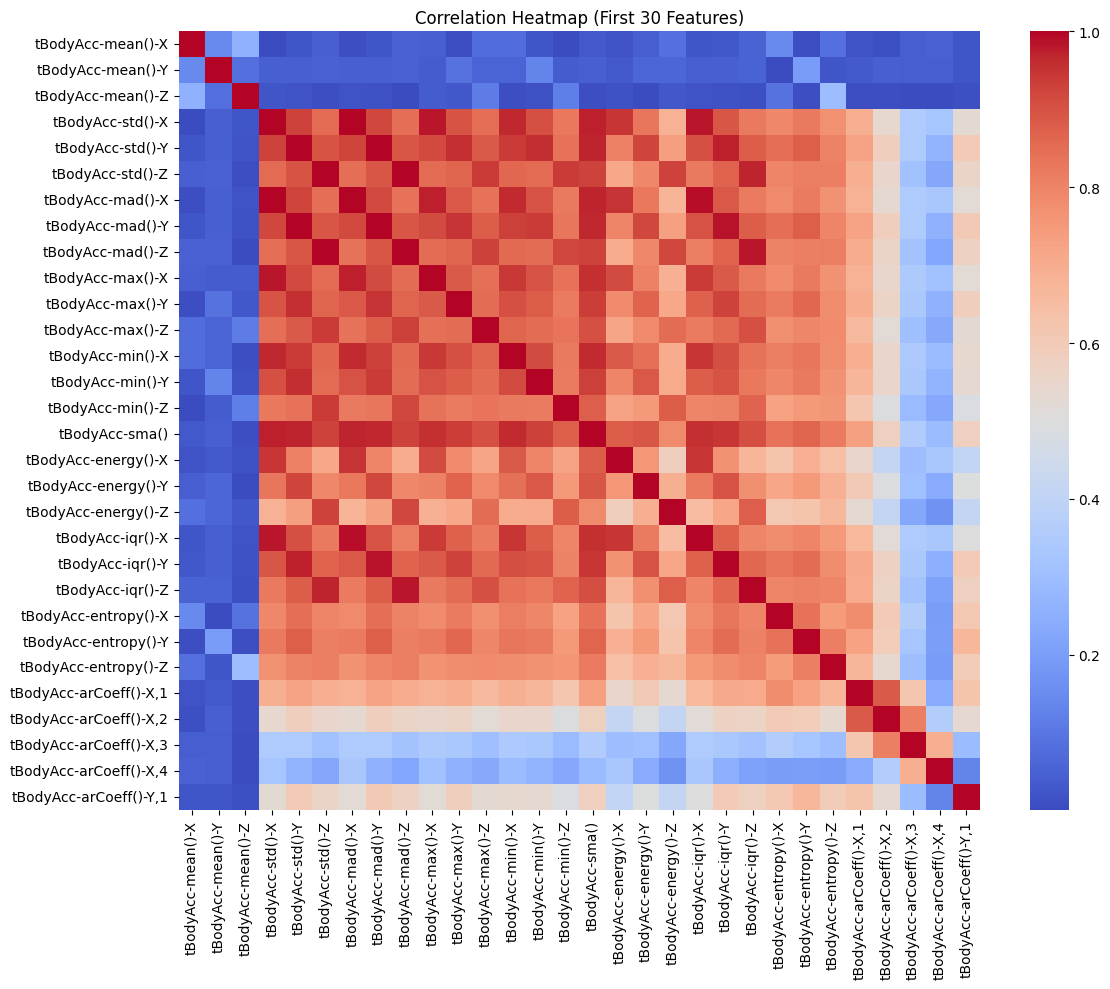

🔁 Highly correlated features (>0.95): 308
📉 Low variance features (<0.01): 37


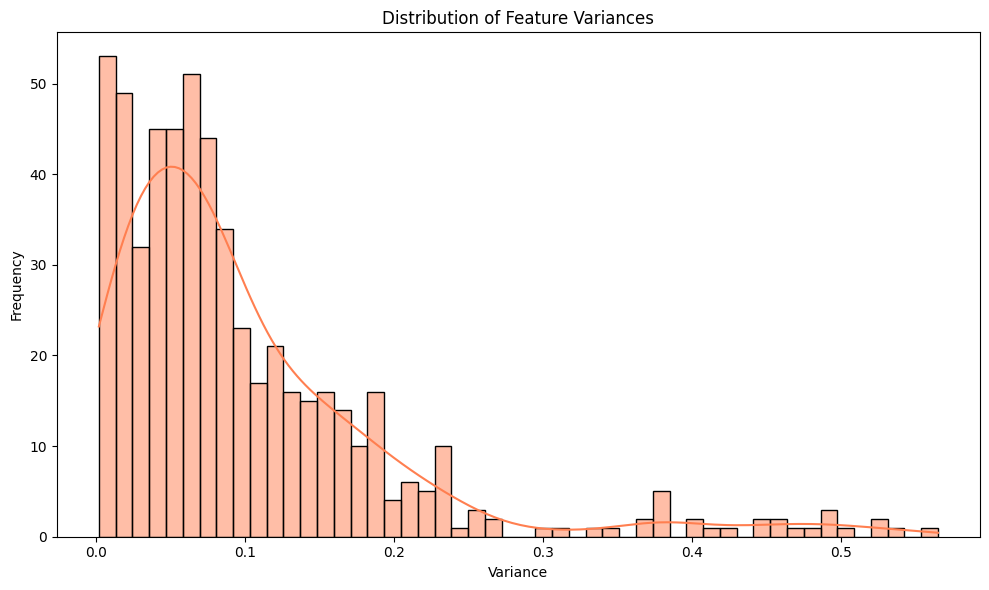

In [8]:
# ================================
# BLOCK 1: Prepare X and y, Correlation, and Variance Analysis
# ================================



# Prepare X: All features; y: target activity labels
X = train_df.drop(columns=["Subject", "Activity", "ActivityName"])
y = train_df["Activity"]

# Compute the absolute correlation matrix for all features
corr_matrix = X.corr().abs()

# Plot a heatmap of the correlation matrix for a subset of features (for visual clarity)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.iloc[:30, :30], cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap (First 30 Features)")
plt.tight_layout()
plt.show()

# Identify highly correlated features (correlation > 0.95)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [col for col in upper.columns if any(upper[col] > 0.95)]
print(f"🔁 Highly correlated features (>0.95): {len(high_corr_features)}")

# Apply VarianceThreshold to remove low variance features (threshold = 0.01)
var_thresh = VarianceThreshold(threshold=0.01)
var_thresh.fit(X)
low_variance_features = X.columns[~var_thresh.get_support()]
print(f"📉 Low variance features (<0.01): {len(low_variance_features)}")

# Plot distribution of variances for all features to see the overall spread
feature_variances = X.var()
plt.figure(figsize=(10, 6))
sns.histplot(feature_variances, bins=50, kde=True, color='coral')
plt.title("Distribution of Feature Variances")
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

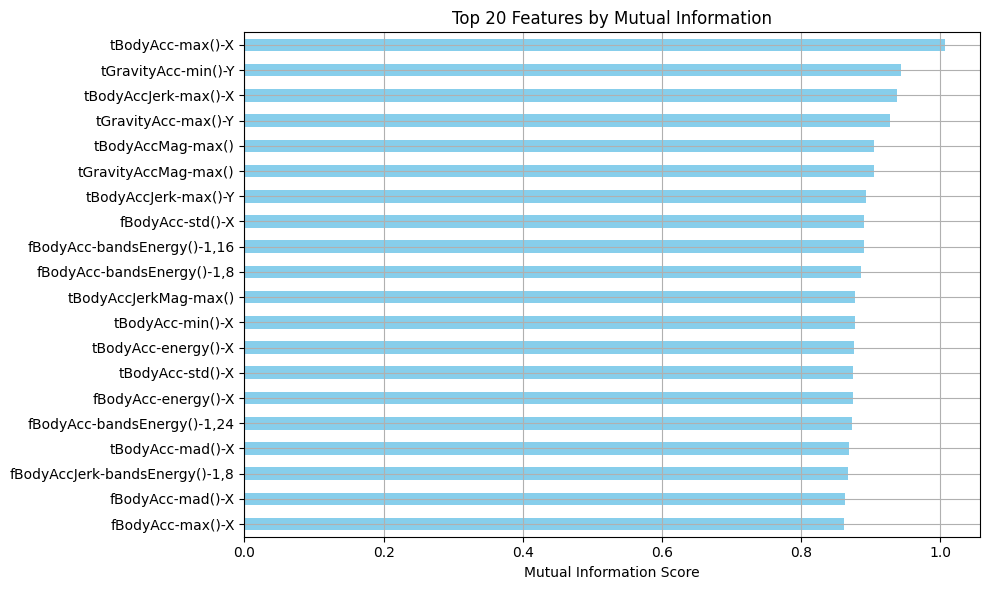

Top 10 Features by Mutual Information:
tBodyAcc-max()-X               1.006890
tGravityAcc-min()-Y            0.944219
tBodyAccJerk-max()-X           0.937908
tGravityAcc-max()-Y            0.928346
tBodyAccMag-max()              0.904677
tGravityAccMag-max()           0.904660
tBodyAccJerk-max()-Y           0.892837
fBodyAcc-std()-X               0.890922
fBodyAcc-bandsEnergy()-1,16    0.890766
fBodyAcc-bandsEnergy()-1,8     0.886330
dtype: float64


In [9]:
# ================================
# BLOCK 2: Mutual Information Feature Selection
# ================================

from sklearn.feature_selection import SelectKBest, mutual_info_classif

# SelectKBest with mutual information on all features in X and target y
mi_selector = SelectKBest(mutual_info_classif, k=20)
mi_selector.fit(X, y)
mi_scores = pd.Series(mi_selector.scores_, index=X.columns).sort_values(ascending=False)

# Plot the top 20 features by mutual information score
plt.figure(figsize=(10, 6))
mi_scores.head(20).plot(kind='barh', color='skyblue')
plt.title("Top 20 Features by Mutual Information")
plt.gca().invert_yaxis()  # highest scores at the top
plt.xlabel("Mutual Information Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the top 10 features for further inspection
print("Top 10 Features by Mutual Information:")
print(mi_scores.head(10))


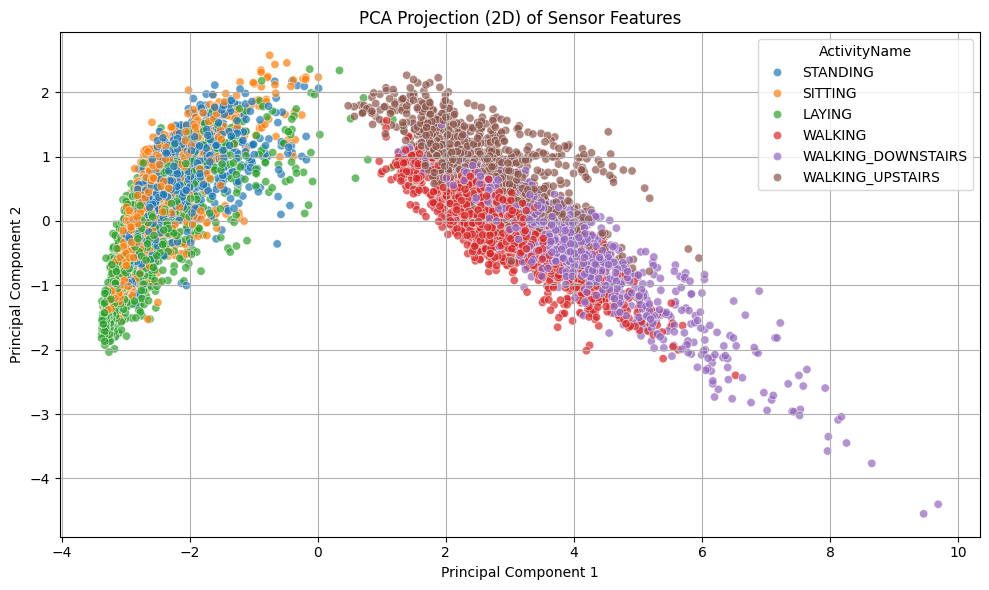

Explained Variance Ratio: [0.6198727  0.05095767]


In [10]:
# ================================
# BLOCK 3: PCA Dimensionality Reduction and Visualization
# ================================

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Scale the features to [0, 1] range for PCA
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame from the PCA results and add the activity labels
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["ActivityName"] = train_df["ActivityName"]

# Scatter plot of the PCA projection, colored by activity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="ActivityName", palette="tab10", alpha=0.7)
plt.title("PCA Projection (2D) of Sensor Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print explained variance ratio for insight on PCA performance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/4126758889.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="ActivityName", y=feature, data=train_df, palette="Set3")
/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/4126758889.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="ActivityName", y=feature, data=train_df, palette="Set3")
/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/4126758889.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="ActivityName", y=feature, data=train_df,

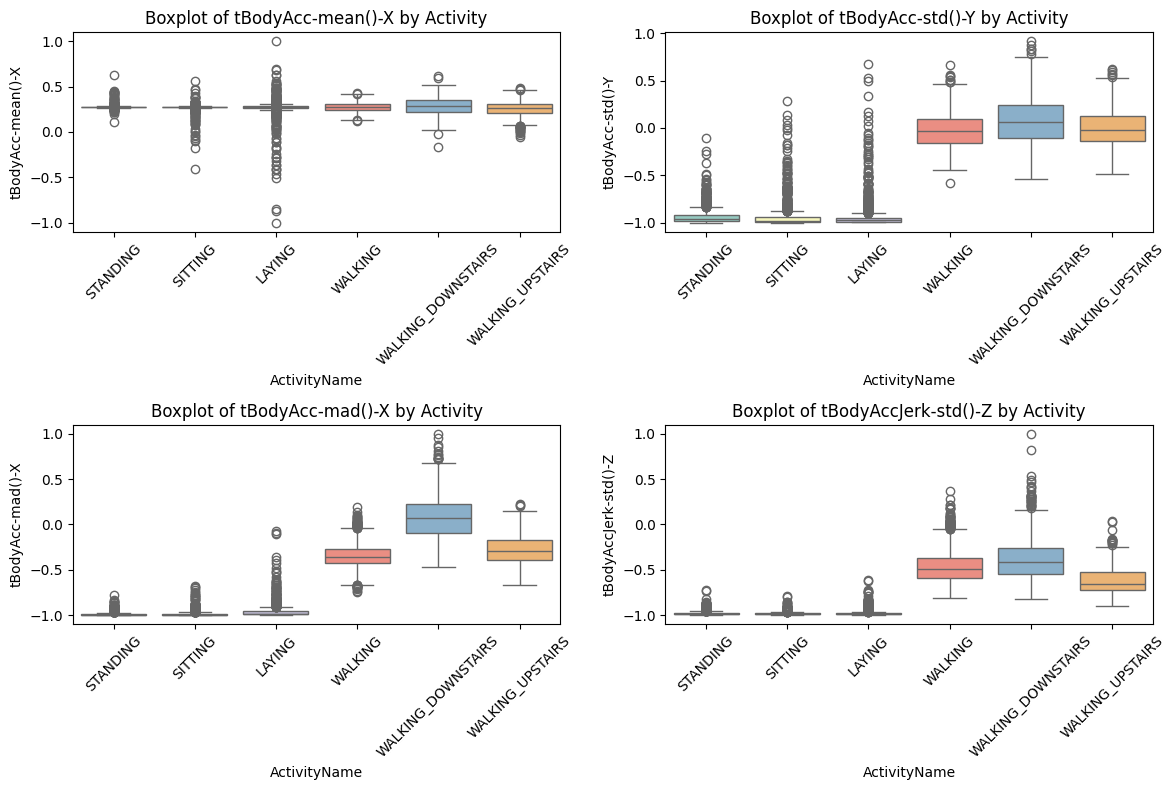

/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/4126758889.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="ActivityName", y=feature, data=train_df, palette="Set2", inner="quartile")
/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/4126758889.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="ActivityName", y=feature, data=train_df, palette="Set2", inner="quartile")
/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/4126758889.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplo

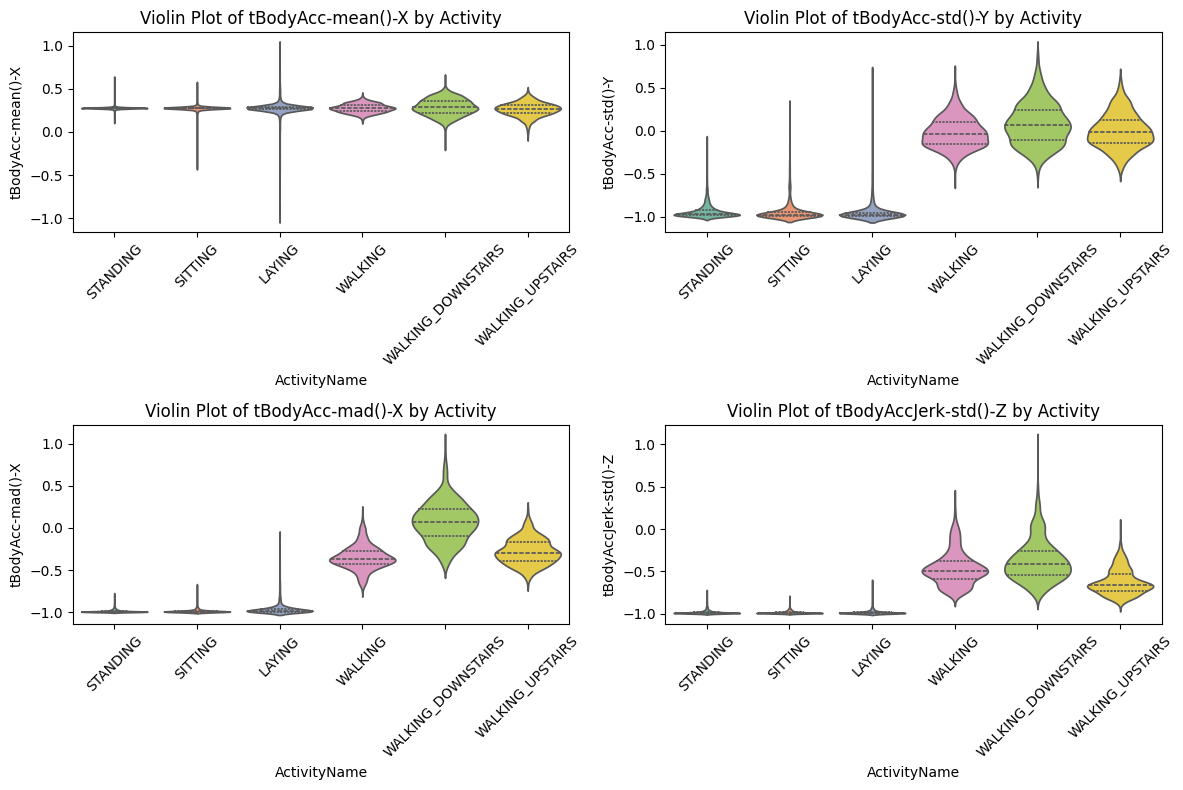

In [11]:
# ================================
# BLOCK 4: Additional Feature Distribution Analysis
# ================================

# Select a few representative features (you can choose based on domain knowledge or MI results)
selected_features = ["tBodyAcc-mean()-X", "tBodyAcc-std()-Y", "tBodyAcc-mad()-X", "tBodyAccJerk-std()-Z"]

# Plot boxplots for the selected features by activity
plt.figure(figsize=(12, 8))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x="ActivityName", y=feature, data=train_df, palette="Set3")
    plt.xticks(rotation=45)
    plt.title(f"Boxplot of {feature} by Activity")
plt.tight_layout()
plt.show()

# Plot violin plots for the same features to inspect the full distribution
plt.figure(figsize=(12, 8))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(x="ActivityName", y=feature, data=train_df, palette="Set2", inner="quartile")
    plt.xticks(rotation=45)
    plt.title(f"Violin Plot of {feature} by Activity")
plt.tight_layout()
plt.show()


In [12]:
# ================================
# BLOCK 1: Drop Highly Correlated & Low Variance Features
# ================================

from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd

# Calculate the absolute correlation matrix for all features in X
corr_matrix = X.corr().abs()

# Compute the upper triangle of the correlation matrix (to avoid duplicate entries)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify features where any correlation value is higher than 0.95
high_corr_features = [col for col in upper.columns if any(upper[col] > 0.95)]
print(f"🔁 Highly correlated features (>0.95): {len(high_corr_features)}")

# Apply VarianceThreshold to remove features with variance below 0.01
var_thresh = VarianceThreshold(threshold=0.01)
var_thresh.fit(X)
low_variance_features = X.columns[~var_thresh.get_support()]
print(f"📉 Low variance features (<0.01): {len(low_variance_features)}")

# Combine features to drop (both high correlation and low variance)
features_to_drop = list(set(high_corr_features).union(set(low_variance_features)))

# Drop the selected features from X to obtain a cleaned feature matrix
X_cleaned = X.drop(columns=features_to_drop)
print(f"Features remaining after dropping: {X_cleaned.shape[1]}")


🔁 Highly correlated features (>0.95): 308
📉 Low variance features (<0.01): 37
Features remaining after dropping: 233


In [13]:
# ================================
# BLOCK 2: Normalize the Features
# ================================

from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the cleaned features
X_normalized = scaler.fit_transform(X_cleaned)

# Convert the normalized array back to a DataFrame with the same column names as X_cleaned
X_normalized_df = pd.DataFrame(X_normalized, columns=X_cleaned.columns)

# Display summary information (optional)
print("Normalized feature data shape:", X_normalized_df.shape)


Normalized feature data shape: (7352, 233)


In [14]:
# ================================
# BLOCK 3: Encode Labels and Build Final DataFrame
# ================================

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder and encode the activity labels from train_df
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_df["Activity"])

# Build the final DataFrame by concatenating the following:
# - The "Subject" column (reset index to align properly)
# - A new DataFrame for the encoded activity values
# - The normalized features DataFrame
prepared_df = pd.concat([
    train_df[["Subject"]].reset_index(drop=True),
    pd.DataFrame({"Activity": y_encoded}),
    X_normalized_df
], axis=1)

# (Optional) Map the encoded activity labels back to human-readable labels for easier interpretation
prepared_df["ActivityName"] = label_encoder.inverse_transform(y_encoded)


In [15]:
# ================================
# BLOCK 4: Preview the Final Prepared Data
# ================================

print("📦 Prepared data sample:")
display(prepared_df.head(20))  # Best viewed in a Jupyter Notebook environment


📦 Prepared data sample:


,Subject,Activity,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-max()-Z,tBodyAcc-min()-Z,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-entropy()-X,...,fBodyBodyGyroMag-skewness(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)",ActivityName
0,1,4,-0.868814,-0.939441,-0.737529,-0.637379,0.738383,-0.775696,-0.670496,-0.649898,...,2.571343,-0.616153,-0.706661,-0.795359,0.025960,-0.360603,0.062940,-0.778427,-0.026080,5
1,1,4,-0.875426,-0.923902,-0.849304,-0.889197,0.766503,-0.775105,-0.687585,-1.304893,...,-0.253097,-0.633698,-0.706661,0.130614,-0.897357,0.133011,-0.021461,-1.218805,1.484470,5
2,1,4,-0.869039,-0.907760,-0.893785,-0.889197,0.822606,-0.774088,-0.692379,-1.043324,...,-0.862529,-0.641077,2.398628,1.152336,-0.260878,-0.377840,0.391976,0.151207,1.704201,5
3,1,4,-0.870626,-0.940022,-0.921805,-0.927662,0.817653,-0.774691,-0.692533,-1.118413,...,0.072130,-0.640381,-0.263048,1.112769,0.591045,-0.135025,-0.033637,1.037851,-1.003019,5
4,1,4,-0.875188,-0.934878,-0.921343,-0.910626,0.817653,-0.775640,-0.693672,-1.457712,...,-0.785768,-0.649103,-0.263048,-0.149577,-0.138515,0.340406,0.268486,1.125918,-1.276282,5
5,1,4,-0.873397,-0.954117,-0.933139,-0.904026,0.844693,-0.775649,-0.694396,-1.383748,...,-0.282901,-0.654800,-0.706661,-0.419721,-0.742707,0.219586,-0.324856,0.437830,-0.757922,5
6,1,4,-0.872474,-0.907757,-0.903754,-0.885047,0.803288,-0.774076,-0.693119,-1.139181,...,-0.208028,-0.646600,-0.706661,0.081880,0.279795,-0.657546,-0.519341,0.009718,-0.384001,5
7,1,4,-0.871668,-0.906847,-0.900094,-0.885047,0.799231,-0.771564,-0.691001,-1.130767,...,-0.470407,-0.646974,-0.706661,0.044181,0.700031,-0.087811,1.320191,-0.938078,0.990421,5
8,1,4,-0.873382,-0.895938,-0.905077,-0.906615,0.799231,-0.773043,-0.692183,-1.237133,...,-0.360501,-0.629394,-0.706661,0.752040,0.117163,0.012681,0.175674,-0.399562,0.258981,5
9,1,4,-0.867755,-0.918844,-0.911221,-0.880491,0.819621,-0.774103,-0.693498,-0.954795,...,1.103588,-0.584233,-0.706661,0.566145,2.014197,-0.086925,-0.289813,-0.808199,-0.135349,5


In [16]:

# Extract features and targets from the prepared DataFrame.
# Assume prepared_df is already created and has columns: Subject, Activity, ActivityName, and normalized features.
X_full = prepared_df.drop(columns=["Subject", "Activity", "ActivityName"])
y_full = prepared_df["Activity"]
groups = prepared_df["Subject"]

print("X_full shape:", X_full.shape)
print("y_full shape:", y_full.shape)
print("Number of unique subjects:", len(np.unique(groups)))

X_full shape: (7352, 233)
y_full shape: (7352,)
Number of unique subjects: 21


Starting LOSO-CV for Logistic Regression:

Fold 1 (Subject 1) -> Accuracy: 0.9914, Cross-Entropy Loss: 0.0185
Fold 2 (Subject 3) -> Accuracy: 0.9707, Cross-Entropy Loss: 0.0885


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 3 (Subject 5) -> Accuracy: 0.8907, Cross-Entropy Loss: 0.5014
Fold 4 (Subject 6) -> Accuracy: 0.8708, Cross-Entropy Loss: 0.6155
Fold 5 (Subject 7) -> Accuracy: 0.8734, Cross-Entropy Loss: 0.4403


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 6 (Subject 8) -> Accuracy: 0.9680, Cross-Entropy Loss: 0.0765
Fold 7 (Subject 11) -> Accuracy: 0.9842, Cross-Entropy Loss: 0.0478


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 8 (Subject 14) -> Accuracy: 0.7152, Cross-Entropy Loss: 1.8406
Fold 9 (Subject 15) -> Accuracy: 0.9878, Cross-Entropy Loss: 0.0560


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 10 (Subject 16) -> Accuracy: 0.7760, Cross-Entropy Loss: 0.8153
Fold 11 (Subject 17) -> Accuracy: 0.9783, Cross-Entropy Loss: 0.0562
Fold 12 (Subject 19) -> Accuracy: 0.9194, Cross-Entropy Loss: 0.1930


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 13 (Subject 21) -> Accuracy: 0.9363, Cross-Entropy Loss: 0.2074
Fold 14 (Subject 22) -> Accuracy: 0.9720, Cross-Entropy Loss: 0.0649
Fold 15 (Subject 23) -> Accuracy: 0.9812, Cross-Entropy Loss: 0.0585


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 16 (Subject 25) -> Accuracy: 0.9462, Cross-Entropy Loss: 0.1648
Fold 17 (Subject 26) -> Accuracy: 0.9719, Cross-Entropy Loss: 0.0724
Fold 18 (Subject 27) -> Accuracy: 0.9894, Cross-Entropy Loss: 0.0343


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 19 (Subject 28) -> Accuracy: 0.9031, Cross-Entropy Loss: 0.3709
Fold 20 (Subject 29) -> Accuracy: 0.9593, Cross-Entropy Loss: 0.1176
Fold 21 (Subject 30) -> Accuracy: 0.9843, Cross-Entropy Loss: 0.0374

Overall LOSO-CV Results (Logistic Regression):


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Fold,Subject,Accuracy,CrossEntropyLoss
0,1,1,0.991354,0.018495
1,2,3,0.970674,0.088537
2,3,5,0.890728,0.501391
3,4,6,0.870769,0.615488
4,5,7,0.873377,0.440295
5,6,8,0.967972,0.076522
6,7,11,0.984177,0.047762
7,8,14,0.715170,1.840626
8,9,15,0.987805,0.056035
9,10,16,0.775956,0.815281



Average Accuracy: 0.9319
Average Cross-Entropy Loss: 0.2799


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


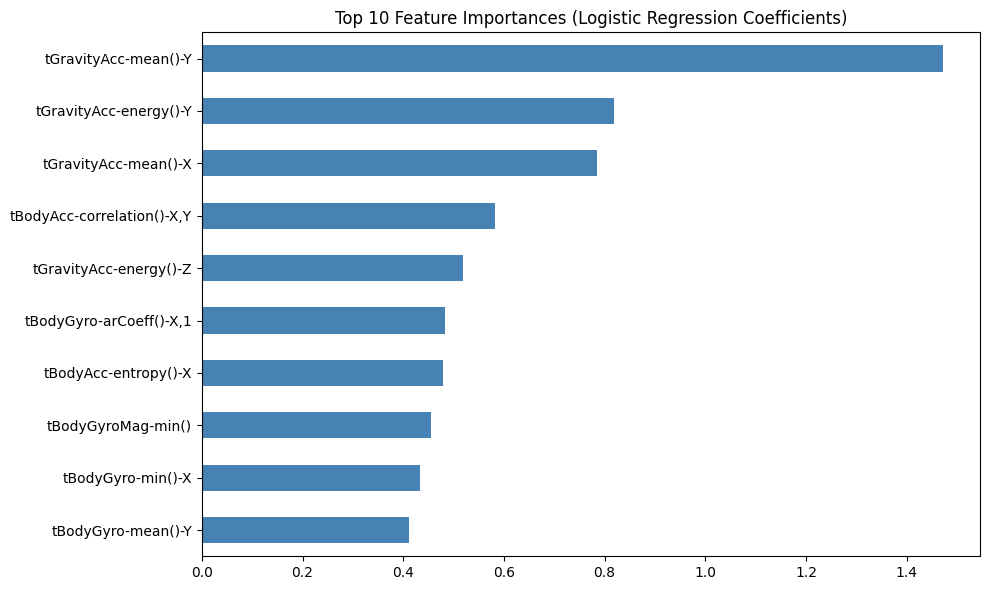

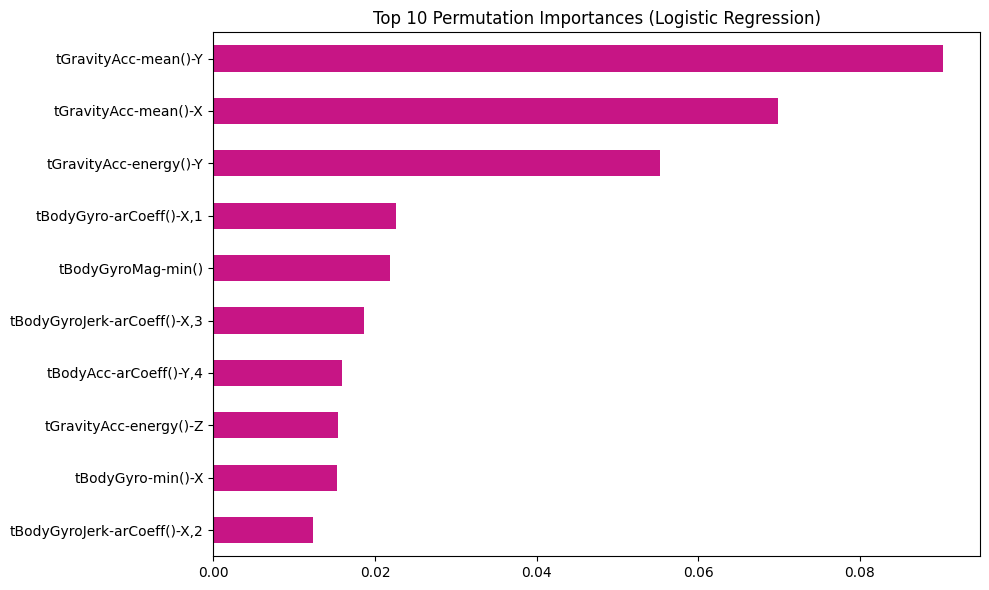


Random Sample Predictions (Logistic Regression):
Sample 1 (Index 1353) -> True: 4, Predicted: 4
Sample 2 (Index 6235) -> True: 2, Predicted: 2
Sample 3 (Index 2713) -> True: 5, Predicted: 5
Sample 4 (Index 5236) -> True: 2, Predicted: 2
Sample 5 (Index 1870) -> True: 3, Predicted: 3
Sample 6 (Index 2011) -> True: 3, Predicted: 3
Sample 7 (Index 7120) -> True: 3, Predicted: 3
Sample 8 (Index 5817) -> True: 3, Predicted: 3
Sample 9 (Index 6546) -> True: 6, Predicted: 6
Sample 10 (Index 5758) -> True: 6, Predicted: 6


In [17]:
# ================================
# Block B: Logistic Regression Model (LR_Model)
# ================================
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

# --- LOSO-CV Training & Evaluation for Logistic Regression ---
logo = LeaveOneGroupOut()
lr_fold_accuracies = []
lr_fold_losses = []
lr_fold_subjects = []

print("Starting LOSO-CV for Logistic Regression:\n")
for fold, (train_idx, test_idx) in enumerate(logo.split(X_full, y_full, groups)):
    test_subject = groups.iloc[test_idx].unique()[0]
    lr_fold_subjects.append(test_subject)
    
    X_train_fold = X_full.iloc[train_idx]
    X_test_fold  = X_full.iloc[test_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_test_fold  = y_full.iloc[test_idx]
    
    lr_model = LogisticRegression(max_iter=300, multi_class='multinomial', solver='lbfgs', random_state=42)
    lr_model.fit(X_train_fold, y_train_fold)
    
    y_pred = lr_model.predict(X_test_fold)
    y_proba = lr_model.predict_proba(X_test_fold)
    
    acc = accuracy_score(y_test_fold, y_pred)
    ce_loss = log_loss(y_test_fold, y_proba)
    lr_fold_accuracies.append(acc)
    lr_fold_losses.append(ce_loss)
    
    print(f"Fold {fold+1} (Subject {test_subject}) -> Accuracy: {acc:.4f}, Cross-Entropy Loss: {ce_loss:.4f}")

results_df_lr = pd.DataFrame({
    "Fold": range(1, len(lr_fold_accuracies)+1),
    "Subject": lr_fold_subjects,
    "Accuracy": lr_fold_accuracies,
    "CrossEntropyLoss": lr_fold_losses
})
print("\nOverall LOSO-CV Results (Logistic Regression):")
display(results_df_lr)
print("\nAverage Accuracy: {:.4f}".format(np.mean(lr_fold_accuracies)))
print("Average Cross-Entropy Loss: {:.4f}".format(np.mean(lr_fold_losses)))

# --- Final Model Training on Full Data ---
final_lr_model = LogisticRegression(max_iter=300, multi_class='multinomial', solver='lbfgs', random_state=42)
final_lr_model.fit(X_full, y_full)

# --- Feature Importance Extraction for Logistic Regression ---
# For multinomial LR, we average the absolute coefficients across classes.
lr_coef_avg = np.mean(np.abs(final_lr_model.coef_), axis=0)
lr_importances = pd.Series(lr_coef_avg, index=X_full.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
lr_importances.head(10).plot(kind='barh', color='steelblue')
plt.title("Top 10 Feature Importances (Logistic Regression Coefficients)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- Permutation Importance ---
perm_lr = permutation_importance(final_lr_model, X_full, y_full, n_repeats=10, random_state=42)
perm_lr_series = pd.Series(perm_lr.importances_mean, index=X_full.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
perm_lr_series.head(10).plot(kind='barh', color='mediumvioletred')
plt.title("Top 10 Permutation Importances (Logistic Regression)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- Random Sample Testing ---
random_indices = np.random.choice(X_full.index, size=10, replace=False)
test_samples = X_full.iloc[random_indices]
true_labels = y_full.iloc[random_indices]
predicted_labels = final_lr_model.predict(test_samples)
predicted_activities = label_encoder.inverse_transform(predicted_labels)
true_activities = label_encoder.inverse_transform(true_labels)
print("\nRandom Sample Predictions (Logistic Regression):")
for i, idx in enumerate(random_indices):
    print(f"Sample {i+1} (Index {idx}) -> True: {true_activities[i]}, Predicted: {predicted_activities[i]}")


Starting LOSO-CV for Random Forest:

Fold 1 (Subject 1) -> Accuracy: 0.9625, CE Loss: 0.2448
Fold 2 (Subject 3) -> Accuracy: 0.9853, CE Loss: 0.2560
Fold 3 (Subject 5) -> Accuracy: 0.8146, CE Loss: 0.4459
Fold 4 (Subject 6) -> Accuracy: 0.8615, CE Loss: 0.3928
Fold 5 (Subject 7) -> Accuracy: 0.9448, CE Loss: 0.3342
Fold 6 (Subject 8) -> Accuracy: 0.9466, CE Loss: 0.3225
Fold 7 (Subject 11) -> Accuracy: 0.9842, CE Loss: 0.2456
Fold 8 (Subject 14) -> Accuracy: 0.7461, CE Loss: 0.5826
Fold 9 (Subject 15) -> Accuracy: 1.0000, CE Loss: 0.2346
Fold 10 (Subject 16) -> Accuracy: 0.8361, CE Loss: 0.4364
Fold 11 (Subject 17) -> Accuracy: 0.9565, CE Loss: 0.2604
Fold 12 (Subject 19) -> Accuracy: 0.8667, CE Loss: 0.3718
Fold 13 (Subject 21) -> Accuracy: 0.7525, CE Loss: 0.4107
Fold 14 (Subject 22) -> Accuracy: 0.9626, CE Loss: 0.2514
Fold 15 (Subject 23) -> Accuracy: 0.9731, CE Loss: 0.2856
Fold 16 (Subject 25) -> Accuracy: 0.8386, CE Loss: 0.4655
Fold 17 (Subject 26) -> Accuracy: 1.0000, CE Loss:

,Fold,Subject,Accuracy,CrossEntropyLoss
0,1,1,0.962536,0.244766
1,2,3,0.985337,0.255996
2,3,5,0.814570,0.445888
3,4,6,0.861538,0.392776
4,5,7,0.944805,0.334169
5,6,8,0.946619,0.322457
6,7,11,0.984177,0.245595
7,8,14,0.746130,0.582615
8,9,15,1.000000,0.234551
9,10,16,0.836066,0.436363



Average Accuracy: 0.9176
Average Cross-Entropy Loss: 0.3187


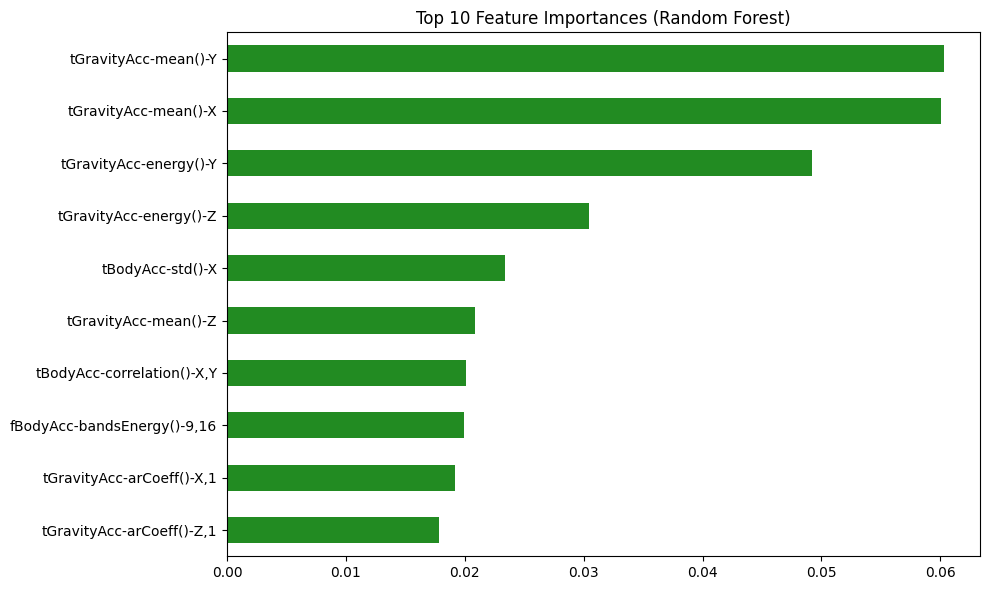

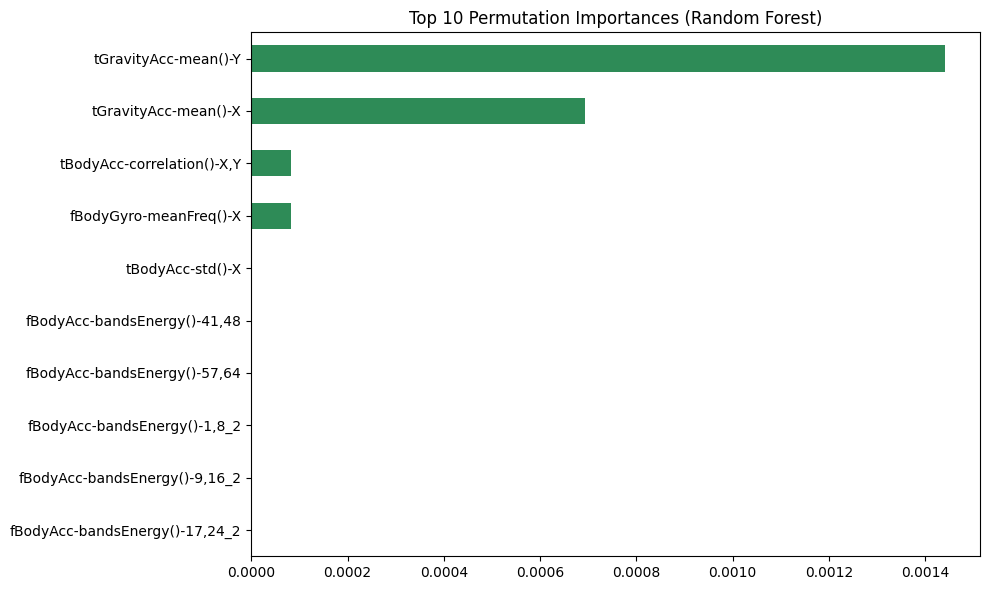


Random Sample Predictions (Random Forest):
Sample 1 (Index 1343) -> True: 4, Predicted: 4
Sample 2 (Index 4679) -> True: 2, Predicted: 2
Sample 3 (Index 4155) -> True: 2, Predicted: 2
Sample 4 (Index 1734) -> True: 3, Predicted: 3
Sample 5 (Index 6407) -> True: 2, Predicted: 2
Sample 6 (Index 1997) -> True: 1, Predicted: 1
Sample 7 (Index 2062) -> True: 5, Predicted: 5
Sample 8 (Index 3356) -> True: 1, Predicted: 1
Sample 9 (Index 3840) -> True: 4, Predicted: 4
Sample 10 (Index 6314) -> True: 4, Predicted: 4


In [18]:
# ================================
# Block C: Random Forest Model (RF_Model)
# ================================
from sklearn.ensemble import RandomForestClassifier

# --- LOSO-CV Training & Evaluation for Random Forest ---
logo = LeaveOneGroupOut()
rf_fold_accuracies = []
rf_fold_losses = []
rf_fold_subjects = []

print("Starting LOSO-CV for Random Forest:\n")
for fold, (train_idx, test_idx) in enumerate(logo.split(X_full, y_full, groups)):
    test_subject = groups.iloc[test_idx].unique()[0]
    rf_fold_subjects.append(test_subject)
    
    X_train_fold = X_full.iloc[train_idx]
    X_test_fold  = X_full.iloc[test_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_test_fold  = y_full.iloc[test_idx]
    
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_fold, y_train_fold)
    
    y_pred = rf_model.predict(X_test_fold)
    y_proba = rf_model.predict_proba(X_test_fold)
    
    acc = accuracy_score(y_test_fold, y_pred)
    ce_loss = log_loss(y_test_fold, y_proba)
    rf_fold_accuracies.append(acc)
    rf_fold_losses.append(ce_loss)
    
    print(f"Fold {fold+1} (Subject {test_subject}) -> Accuracy: {acc:.4f}, CE Loss: {ce_loss:.4f}")

results_df_rf = pd.DataFrame({
    "Fold": range(1, len(rf_fold_accuracies)+1),
    "Subject": rf_fold_subjects,
    "Accuracy": rf_fold_accuracies,
    "CrossEntropyLoss": rf_fold_losses
})
print("\nOverall LOSO-CV Results (Random Forest):")
display(results_df_rf)
print("\nAverage Accuracy: {:.4f}".format(np.mean(rf_fold_accuracies)))
print("Average Cross-Entropy Loss: {:.4f}".format(np.mean(rf_fold_losses)))

# --- Final Model Training on Full Data ---
final_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_rf_model.fit(X_full, y_full)

# --- Feature Importance from Random Forest ---
rf_importances = pd.Series(final_rf_model.feature_importances_, index=X_full.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
rf_importances.head(10).plot(kind='barh', color='forestgreen')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- Permutation Importance ---
from sklearn.inspection import permutation_importance
perm_rf = permutation_importance(final_rf_model, X_full, y_full, n_repeats=10, random_state=42)
perm_rf_series = pd.Series(perm_rf.importances_mean, index=X_full.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
perm_rf_series.head(10).plot(kind='barh', color='seagreen')
plt.title("Top 10 Permutation Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- Random Sample Testing ---
random_indices = np.random.choice(X_full.index, size=10, replace=False)
test_samples = X_full.iloc[random_indices]
true_labels = y_full.iloc[random_indices]
predicted_labels = final_rf_model.predict(test_samples)
predicted_activities = label_encoder.inverse_transform(predicted_labels)
true_activities = label_encoder.inverse_transform(true_labels)
print("\nRandom Sample Predictions (Random Forest):")
for i, idx in enumerate(random_indices):
    print(f"Sample {i+1} (Index {idx}) -> True: {true_activities[i]}, Predicted: {predicted_activities[i]}")


In [22]:
# ================================
# Block D: k-Nearest Neighbors Model (kNN_Model)
# ================================
from sklearn.neighbors import KNeighborsClassifier

logo = LeaveOneGroupOut()
knn_fold_accuracies = []
knn_fold_losses = []
knn_fold_subjects = []

print("Starting LOSO-CV for k-Nearest Neighbors:\n")
for fold, (train_idx, test_idx) in enumerate(logo.split(X_full, y_full, groups)):
    test_subject = groups.iloc[test_idx].unique()[0]
    knn_fold_subjects.append(test_subject)
    
    X_train_fold = X_full.iloc[train_idx]
    X_test_fold  = X_full.iloc[test_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_test_fold  = y_full.iloc[test_idx]
    
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train_fold, y_train_fold)
    
    y_pred = knn_model.predict(X_test_fold)
    y_proba = knn_model.predict_proba(X_test_fold)
    
    acc = accuracy_score(y_test_fold, y_pred)
    ce_loss = log_loss(y_test_fold, y_proba)
    knn_fold_accuracies.append(acc)
    knn_fold_losses.append(ce_loss)
    
    print(f"Fold {fold+1} (Subject {test_subject}) -> Accuracy: {acc:.4f}, CE Loss: {ce_loss:.4f}")

results_df_knn = pd.DataFrame({
    "Fold": range(1, len(knn_fold_accuracies)+1),
    "Subject": knn_fold_subjects,
    "Accuracy": knn_fold_accuracies,
    "CrossEntropyLoss": knn_fold_losses
})
print("\nOverall LOSO-CV Results (k-NN):")
display(results_df_knn)
print("\nAverage Accuracy: {:.4f}".format(np.mean(knn_fold_accuracies)))
print("Average Cross-Entropy Loss: {:.4f}".format(np.mean(knn_fold_losses)))

# --- Final k-NN Model Training ---
final_knn_model = KNeighborsClassifier(n_neighbors=5)
final_knn_model.fit(X_full, y_full)
# (Permutation importance can be computed similarly if needed)

# --- Random Sample Testing for k-NN ---
random_indices = np.random.choice(X_full.index, size=10, replace=False)
test_samples = X_full.iloc[random_indices]
true_labels = y_full.iloc[random_indices]
predicted_labels = final_knn_model.predict(test_samples)
predicted_activities = label_encoder.inverse_transform(predicted_labels)
true_activities = label_encoder.inverse_transform(true_labels)
print("\nRandom Sample Predictions (k-NN):")
for i, idx in enumerate(random_indices):
    print(f"Sample {i+1} (Index {idx}) -> True: {true_activities[i]}, Predicted: {predicted_activities[i]}")


Starting LOSO-CV for k-Nearest Neighbors:

Fold 1 (Subject 1) -> Accuracy: 0.8761, CE Loss: 0.7372
Fold 2 (Subject 3) -> Accuracy: 0.8534, CE Loss: 0.9058
Fold 3 (Subject 5) -> Accuracy: 0.8576, CE Loss: 1.1460
Fold 4 (Subject 6) -> Accuracy: 0.7754, CE Loss: 1.9117
Fold 5 (Subject 7) -> Accuracy: 0.8506, CE Loss: 1.2211
Fold 6 (Subject 8) -> Accuracy: 0.9004, CE Loss: 0.7363
Fold 7 (Subject 11) -> Accuracy: 0.8703, CE Loss: 0.3701
Fold 8 (Subject 14) -> Accuracy: 0.7833, CE Loss: 2.6487
Fold 9 (Subject 15) -> Accuracy: 0.8476, CE Loss: 0.9530
Fold 10 (Subject 16) -> Accuracy: 0.6885, CE Loss: 2.6123
Fold 11 (Subject 17) -> Accuracy: 0.8125, CE Loss: 1.4594
Fold 12 (Subject 19) -> Accuracy: 0.8389, CE Loss: 1.5633
Fold 13 (Subject 21) -> Accuracy: 0.8505, CE Loss: 1.0443
Fold 14 (Subject 22) -> Accuracy: 0.9346, CE Loss: 0.2731
Fold 15 (Subject 23) -> Accuracy: 0.8925, CE Loss: 0.4410
Fold 16 (Subject 25) -> Accuracy: 0.7726, CE Loss: 3.0166
Fold 17 (Subject 26) -> Accuracy: 0.9005, CE

,Fold,Subject,Accuracy,CrossEntropyLoss
0,1,1,0.876081,0.737151
1,2,3,0.853372,0.905803
2,3,5,0.857616,1.145982
3,4,6,0.775385,1.911699
4,5,7,0.850649,1.221076
5,6,8,0.900356,0.736285
6,7,11,0.870253,0.370133
7,8,14,0.783282,2.648687
8,9,15,0.847561,0.953031
9,10,16,0.688525,2.612264



Average Accuracy: 0.8441
Average Cross-Entropy Loss: 1.2456

Random Sample Predictions (k-NN):
Sample 1 (Index 5234) -> True: 3, Predicted: 3
Sample 2 (Index 6403) -> True: 3, Predicted: 3
Sample 3 (Index 4331) -> True: 3, Predicted: 3
Sample 4 (Index 1647) -> True: 4, Predicted: 4
Sample 5 (Index 2030) -> True: 3, Predicted: 3
Sample 6 (Index 3010) -> True: 3, Predicted: 3
Sample 7 (Index 6631) -> True: 5, Predicted: 5
Sample 8 (Index 2894) -> True: 5, Predicted: 5
Sample 9 (Index 5442) -> True: 3, Predicted: 3
Sample 10 (Index 5801) -> True: 1, Predicted: 1


In [20]:
# ================================
# Block E: Support Vector Machine Model (SVM_Model)
# ================================
from sklearn.svm import SVC

logo = LeaveOneGroupOut()
svm_fold_accuracies = []
svm_fold_losses = []
svm_fold_subjects = []

print("Starting LOSO-CV for SVM:\n")
for fold, (train_idx, test_idx) in enumerate(logo.split(X_full, y_full, groups)):
    test_subject = groups.iloc[test_idx].unique()[0]
    svm_fold_subjects.append(test_subject)
    
    X_train_fold = X_full.iloc[train_idx]
    X_test_fold  = X_full.iloc[test_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_test_fold  = y_full.iloc[test_idx]
    
    svm_model = SVC(kernel='rbf', probability=True, random_state=42)
    svm_model.fit(X_train_fold, y_train_fold)
    
    y_pred = svm_model.predict(X_test_fold)
    y_proba = svm_model.predict_proba(X_test_fold)
    
    acc = accuracy_score(y_test_fold, y_pred)
    ce_loss = log_loss(y_test_fold, y_proba)
    svm_fold_accuracies.append(acc)
    svm_fold_losses.append(ce_loss)
    
    print(f"Fold {fold+1} (Subject {test_subject}) -> Accuracy: {acc:.4f}, CE Loss: {ce_loss:.4f}")

results_df_svm = pd.DataFrame({
    "Fold": range(1, len(svm_fold_accuracies)+1),
    "Subject": svm_fold_subjects,
    "Accuracy": svm_fold_accuracies,
    "CrossEntropyLoss": svm_fold_losses
})
print("\nOverall LOSO-CV Results (SVM):")
display(results_df_svm)
print("\nAverage Accuracy: {:.4f}".format(np.mean(svm_fold_accuracies)))
print("Average Cross-Entropy Loss: {:.4f}".format(np.mean(svm_fold_losses)))

final_svm_model = SVC(kernel='rbf', probability=True, random_state=42)
final_svm_model.fit(X_full, y_full)

random_indices = np.random.choice(X_full.index, size=10, replace=False)
test_samples = X_full.iloc[random_indices]
true_labels = y_full.iloc[random_indices]
predicted_labels = final_svm_model.predict(test_samples)
predicted_activities = label_encoder.inverse_transform(predicted_labels)
true_activities = label_encoder.inverse_transform(true_labels)
print("\nRandom Sample Predictions (SVM):")
for i, idx in enumerate(random_indices):
    print(f"Sample {i+1} (Index {idx}) -> True: {true_activities[i]}, Predicted: {predicted_activities[i]}")


Starting LOSO-CV for SVM:

Fold 1 (Subject 1) -> Accuracy: 0.9914, CE Loss: 0.0367
Fold 2 (Subject 3) -> Accuracy: 0.9765, CE Loss: 0.0723
Fold 3 (Subject 5) -> Accuracy: 0.8841, CE Loss: 0.3062
Fold 4 (Subject 6) -> Accuracy: 0.8800, CE Loss: 0.4829
Fold 5 (Subject 7) -> Accuracy: 0.9188, CE Loss: 0.2131
Fold 6 (Subject 8) -> Accuracy: 0.9466, CE Loss: 0.1421
Fold 7 (Subject 11) -> Accuracy: 0.9873, CE Loss: 0.0605
Fold 8 (Subject 14) -> Accuracy: 0.7368, CE Loss: 1.7585
Fold 9 (Subject 15) -> Accuracy: 0.9787, CE Loss: 0.0505
Fold 10 (Subject 16) -> Accuracy: 0.8743, CE Loss: 0.5022
Fold 11 (Subject 17) -> Accuracy: 0.9565, CE Loss: 0.0963
Fold 12 (Subject 19) -> Accuracy: 0.8833, CE Loss: 0.2507
Fold 13 (Subject 21) -> Accuracy: 0.9265, CE Loss: 0.2180
Fold 14 (Subject 22) -> Accuracy: 0.9720, CE Loss: 0.0688
Fold 15 (Subject 23) -> Accuracy: 0.9328, CE Loss: 0.1648
Fold 16 (Subject 25) -> Accuracy: 0.8924, CE Loss: 0.3403
Fold 17 (Subject 26) -> Accuracy: 0.9694, CE Loss: 0.0713
Fo

,Fold,Subject,Accuracy,CrossEntropyLoss
0,1,1,0.991354,0.036675
1,2,3,0.976540,0.072255
2,3,5,0.884106,0.306217
3,4,6,0.880000,0.482893
4,5,7,0.918831,0.213078
5,6,8,0.946619,0.142083
6,7,11,0.987342,0.060539
7,8,14,0.736842,1.758490
8,9,15,0.978659,0.050466
9,10,16,0.874317,0.502152



Average Accuracy: 0.9307
Average Cross-Entropy Loss: 0.2510

Random Sample Predictions (SVM):
Sample 1 (Index 2857) -> True: 2, Predicted: 2
Sample 2 (Index 6462) -> True: 5, Predicted: 5
Sample 3 (Index 3892) -> True: 6, Predicted: 6
Sample 4 (Index 1704) -> True: 1, Predicted: 1
Sample 5 (Index 2586) -> True: 4, Predicted: 4
Sample 6 (Index 4020) -> True: 4, Predicted: 4
Sample 7 (Index 807) -> True: 3, Predicted: 3
Sample 8 (Index 4332) -> True: 3, Predicted: 3
Sample 9 (Index 7082) -> True: 1, Predicted: 1
Sample 10 (Index 3697) -> True: 6, Predicted: 6


Starting LOSO-CV for XGBoost:



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 (Subject 1) -> Accuracy: 0.9856, CE Loss: 0.0370


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 (Subject 3) -> Accuracy: 0.9795, CE Loss: 0.0412


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 (Subject 5) -> Accuracy: 0.8344, CE Loss: 0.5870


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 (Subject 6) -> Accuracy: 0.8615, CE Loss: 0.4672


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 (Subject 7) -> Accuracy: 0.9091, CE Loss: 0.2699


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 6 (Subject 8) -> Accuracy: 0.9359, CE Loss: 0.2253


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 7 (Subject 11) -> Accuracy: 0.9905, CE Loss: 0.0300


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 8 (Subject 14) -> Accuracy: 0.7926, CE Loss: 1.1981


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 9 (Subject 15) -> Accuracy: 1.0000, CE Loss: 0.0178


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 10 (Subject 16) -> Accuracy: 0.7568, CE Loss: 1.3769


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 11 (Subject 17) -> Accuracy: 0.9565, CE Loss: 0.1183


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 12 (Subject 19) -> Accuracy: 0.9556, CE Loss: 0.1262


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 13 (Subject 21) -> Accuracy: 0.8676, CE Loss: 0.2602


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 14 (Subject 22) -> Accuracy: 0.9875, CE Loss: 0.0392


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 15 (Subject 23) -> Accuracy: 0.9731, CE Loss: 0.0663


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 16 (Subject 25) -> Accuracy: 0.8533, CE Loss: 0.4812


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 17 (Subject 26) -> Accuracy: 0.9974, CE Loss: 0.0116


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 18 (Subject 27) -> Accuracy: 0.9973, CE Loss: 0.0057


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 19 (Subject 28) -> Accuracy: 0.8953, CE Loss: 0.6358


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 20 (Subject 29) -> Accuracy: 0.9535, CE Loss: 0.0919


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 21 (Subject 30) -> Accuracy: 0.9817, CE Loss: 0.0354

Overall LOSO-CV Results (XGBoost):


,Fold,Subject,Accuracy,CrossEntropyLoss
0,1,1,0.985591,0.037002
1,2,3,0.979472,0.041242
2,3,5,0.834437,0.586966
3,4,6,0.861538,0.467219
4,5,7,0.909091,0.269898
5,6,8,0.935943,0.225316
6,7,11,0.990506,0.029958
7,8,14,0.792570,1.198116
8,9,15,1.000000,0.017789
9,10,16,0.756831,1.376935



Average Accuracy: 0.9269
Average Cross-Entropy Loss: 0.2915


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


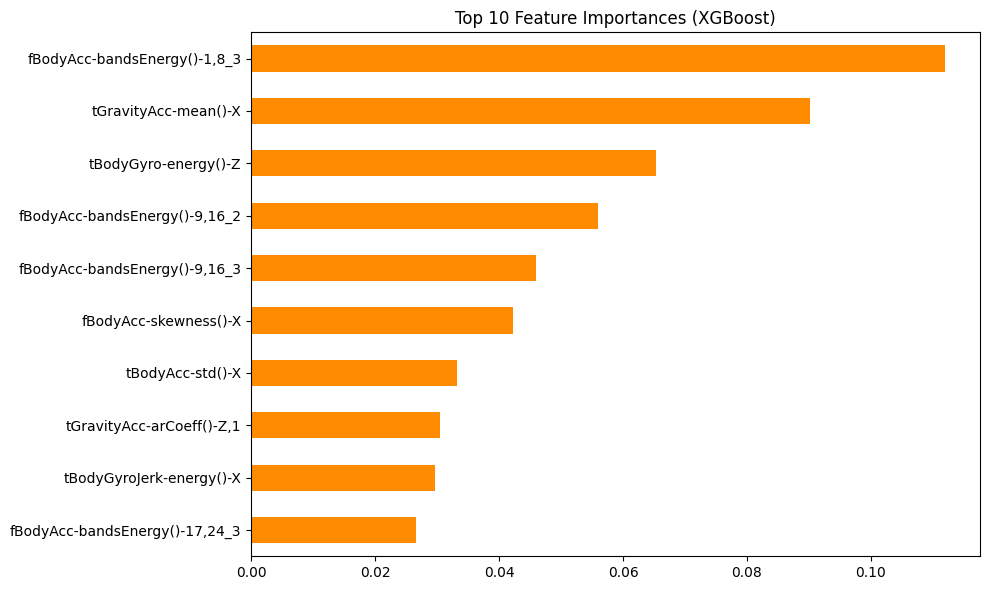

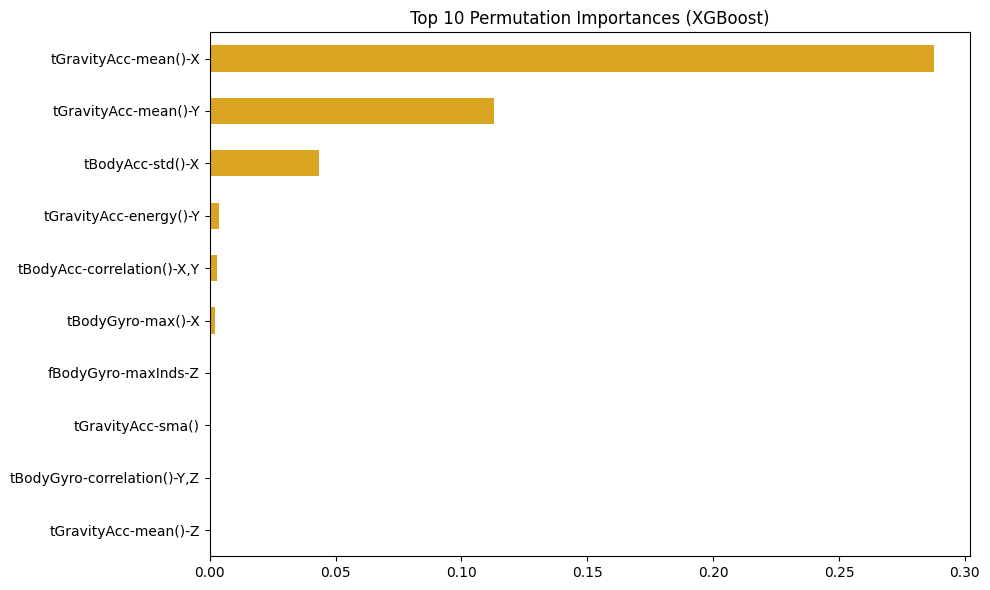


Random Sample Predictions (XGBoost):
Sample 1 (Index 3581) -> True: 2, Predicted: 2
Sample 2 (Index 6427) -> True: 3, Predicted: 3
Sample 3 (Index 4099) -> True: 6, Predicted: 6
Sample 4 (Index 4898) -> True: 5, Predicted: 5
Sample 5 (Index 5010) -> True: 1, Predicted: 1
Sample 6 (Index 7271) -> True: 1, Predicted: 1
Sample 7 (Index 4700) -> True: 5, Predicted: 5
Sample 8 (Index 2255) -> True: 4, Predicted: 4
Sample 9 (Index 6953) -> True: 2, Predicted: 2
Sample 10 (Index 6381) -> True: 1, Predicted: 1


In [23]:
# ================================
# Block F: XGBoost Model (XGB_Model)
# ================================
from xgboost import XGBClassifier

logo = LeaveOneGroupOut()
xgb_fold_accuracies = []
xgb_fold_losses = []
xgb_fold_subjects = []

print("Starting LOSO-CV for XGBoost:\n")
for fold, (train_idx, test_idx) in enumerate(logo.split(X_full, y_full, groups)):
    test_subject = groups.iloc[test_idx].unique()[0]
    xgb_fold_subjects.append(test_subject)
    
    X_train_fold = X_full.iloc[train_idx]
    X_test_fold  = X_full.iloc[test_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_test_fold  = y_full.iloc[test_idx]
    
    xgb_model = XGBClassifier(
        objective='multi:softprob',
        num_class=len(np.unique(y_full)),
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )
    xgb_model.fit(X_train_fold, y_train_fold)
    
    y_pred = xgb_model.predict(X_test_fold)
    y_proba = xgb_model.predict_proba(X_test_fold)
    
    acc = accuracy_score(y_test_fold, y_pred)
    ce_loss = log_loss(y_test_fold, y_proba)
    xgb_fold_accuracies.append(acc)
    xgb_fold_losses.append(ce_loss)
    
    print(f"Fold {fold+1} (Subject {test_subject}) -> Accuracy: {acc:.4f}, CE Loss: {ce_loss:.4f}")

results_df_xgb = pd.DataFrame({
    "Fold": range(1, len(xgb_fold_accuracies)+1),
    "Subject": xgb_fold_subjects,
    "Accuracy": xgb_fold_accuracies,
    "CrossEntropyLoss": xgb_fold_losses
})
print("\nOverall LOSO-CV Results (XGBoost):")
display(results_df_xgb)
print("\nAverage Accuracy: {:.4f}".format(np.mean(xgb_fold_accuracies)))
print("Average Cross-Entropy Loss: {:.4f}".format(np.mean(xgb_fold_losses)))

final_xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_full)),
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
final_xgb_model.fit(X_full, y_full)

# Inherent feature importances:
xgb_importances = pd.Series(final_xgb_model.feature_importances_, index=X_full.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
xgb_importances.head(10).plot(kind='barh', color='darkorange')
plt.title("Top 10 Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Permutation importance for XGBoost
from sklearn.inspection import permutation_importance
perm_xgb = permutation_importance(final_xgb_model, X_full, y_full, n_repeats=10, random_state=42)
perm_xgb_series = pd.Series(perm_xgb.importances_mean, index=X_full.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
perm_xgb_series.head(10).plot(kind='barh', color='goldenrod')
plt.title("Top 10 Permutation Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

random_indices = np.random.choice(X_full.index, size=10, replace=False)
test_samples = X_full.iloc[random_indices]
true_labels = y_full.iloc[random_indices]
predicted_labels = final_xgb_model.predict(test_samples)
predicted_activities = label_encoder.inverse_transform(predicted_labels)
true_activities = label_encoder.inverse_transform(true_labels)
print("\nRandom Sample Predictions (XGBoost):")
for i, idx in enumerate(random_indices):
    print(f"Sample {i+1} (Index {idx}) -> True: {true_activities[i]}, Predicted: {predicted_activities[i]}")


In [24]:
# ================================
# Block G: MLPClassifier Model (MLP_Model)
# ================================
from sklearn.neural_network import MLPClassifier

logo = LeaveOneGroupOut()
mlp_fold_accuracies = []
mlp_fold_losses = []
mlp_fold_subjects = []

print("Starting LOSO-CV for MLPClassifier:\n")
for fold, (train_idx, test_idx) in enumerate(logo.split(X_full, y_full, groups)):
    test_subject = groups.iloc[test_idx].unique()[0]
    mlp_fold_subjects.append(test_subject)
    
    X_train_fold = X_full.iloc[train_idx]
    X_test_fold  = X_full.iloc[test_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_test_fold  = y_full.iloc[test_idx]
    
    mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=300, random_state=42)
    mlp_model.fit(X_train_fold, y_train_fold)
    
    y_pred = mlp_model.predict(X_test_fold)
    y_proba = mlp_model.predict_proba(X_test_fold)
    
    acc = accuracy_score(y_test_fold, y_pred)
    ce_loss = log_loss(y_test_fold, y_proba)
    mlp_fold_accuracies.append(acc)
    mlp_fold_losses.append(ce_loss)
    
    print(f"Fold {fold+1} (Subject {test_subject}) -> Accuracy: {acc:.4f}, CE Loss: {ce_loss:.4f}")

results_df_mlp = pd.DataFrame({
    "Fold": range(1, len(mlp_fold_accuracies)+1),
    "Subject": mlp_fold_subjects,
    "Accuracy": mlp_fold_accuracies,
    "CrossEntropyLoss": mlp_fold_losses
})
print("\nOverall LOSO-CV Results (MLPClassifier):")
display(results_df_mlp)
print("\nAverage Accuracy: {:.4f}".format(np.mean(mlp_fold_accuracies)))
print("Average Cross-Entropy Loss: {:.4f}".format(np.mean(mlp_fold_losses)))

final_mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=300, random_state=42)
final_mlp_model.fit(X_full, y_full)

random_indices = np.random.choice(X_full.index, size=10, replace=False)
test_samples = X_full.iloc[random_indices]
true_labels = y_full.iloc[random_indices]
predicted_labels = final_mlp_model.predict(test_samples)
predicted_activities = label_encoder.inverse_transform(predicted_labels)
true_activities = label_encoder.inverse_transform(true_labels)
print("\nRandom Sample Predictions (MLPClassifier):")
for i, idx in enumerate(random_indices):
    print(f"Sample {i+1} (Index {idx}) -> True: {true_activities[i]}, Predicted: {predicted_activities[i]}")


Starting LOSO-CV for MLPClassifier:

Fold 1 (Subject 1) -> Accuracy: 0.9914, CE Loss: 0.0213
Fold 2 (Subject 3) -> Accuracy: 0.9795, CE Loss: 0.0751
Fold 3 (Subject 5) -> Accuracy: 0.9040, CE Loss: 0.5812
Fold 4 (Subject 6) -> Accuracy: 0.8769, CE Loss: 0.8404
Fold 5 (Subject 7) -> Accuracy: 0.8994, CE Loss: 0.5043
Fold 6 (Subject 8) -> Accuracy: 0.9573, CE Loss: 0.0899
Fold 7 (Subject 11) -> Accuracy: 0.9905, CE Loss: 0.0225
Fold 8 (Subject 14) -> Accuracy: 0.7368, CE Loss: 2.1573
Fold 9 (Subject 15) -> Accuracy: 0.9817, CE Loss: 0.0678
Fold 10 (Subject 16) -> Accuracy: 0.8388, CE Loss: 0.8579
Fold 11 (Subject 17) -> Accuracy: 0.9511, CE Loss: 0.1503
Fold 12 (Subject 19) -> Accuracy: 0.9278, CE Loss: 0.2466
Fold 13 (Subject 21) -> Accuracy: 0.9289, CE Loss: 0.3117
Fold 14 (Subject 22) -> Accuracy: 0.9751, CE Loss: 0.0650
Fold 15 (Subject 23) -> Accuracy: 0.9785, CE Loss: 0.0695
Fold 16 (Subject 25) -> Accuracy: 0.9462, CE Loss: 0.1962
Fold 17 (Subject 26) -> Accuracy: 0.9592, CE Loss:

,Fold,Subject,Accuracy,CrossEntropyLoss
0,1,1,0.991354,0.021279
1,2,3,0.979472,0.075052
2,3,5,0.903974,0.581152
3,4,6,0.876923,0.840350
4,5,7,0.899351,0.504254
5,6,8,0.957295,0.089944
6,7,11,0.990506,0.022496
7,8,14,0.736842,2.157335
8,9,15,0.981707,0.067777
9,10,16,0.838798,0.857923



Average Accuracy: 0.9340
Average Cross-Entropy Loss: 0.3370

Random Sample Predictions (MLPClassifier):
Sample 1 (Index 1409) -> True: 1, Predicted: 1
Sample 2 (Index 5058) -> True: 2, Predicted: 2
Sample 3 (Index 2515) -> True: 3, Predicted: 3
Sample 4 (Index 5623) -> True: 3, Predicted: 3
Sample 5 (Index 4948) -> True: 6, Predicted: 6
Sample 6 (Index 791) -> True: 1, Predicted: 1
Sample 7 (Index 2390) -> True: 5, Predicted: 5
Sample 8 (Index 4847) -> True: 3, Predicted: 3
Sample 9 (Index 3225) -> True: 2, Predicted: 2
Sample 10 (Index 1143) -> True: 2, Predicted: 2


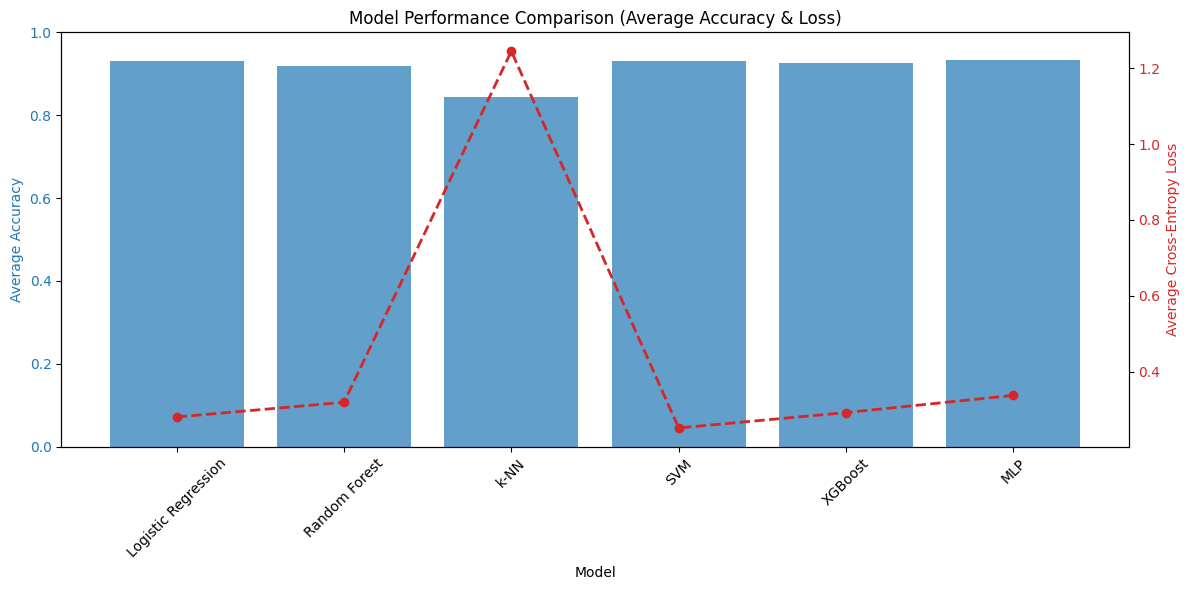

Performance Analysis:
 - Models with high accuracy and low loss are preferable.
 - Compare the blue bars (accuracy) and red line (loss) across models.
 - For instance, if XGBoost shows high accuracy with low loss, it may be the best performer.


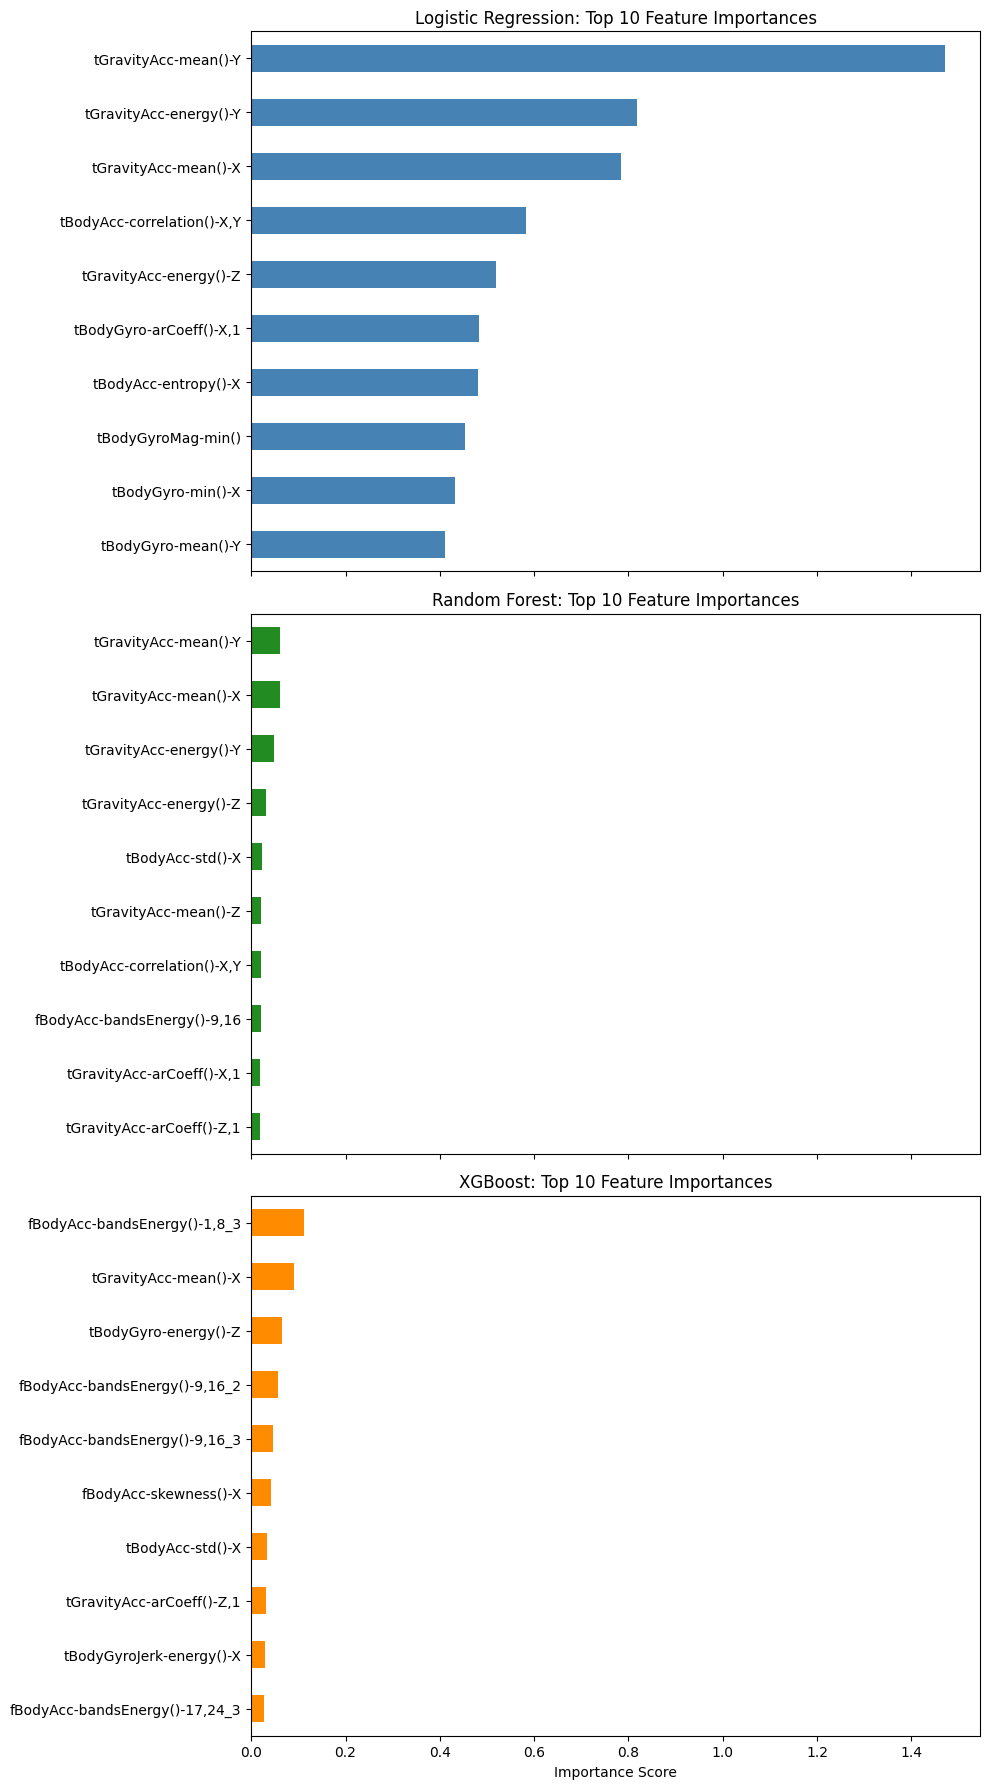

Feature Importance Analysis:
 - The horizontal bar plots show the top 10 most important features for each model.
 - Compare whether the models agree on which features are most predictive.
 - If a feature ranks highly across models, it is likely a key predictor for the activities.


In [26]:
# ================================
# Block H: Model Performance & Feature Importance Comparison
# ================================


# ----------------------------------------------------------
# Part 1: Recompute Feature Importances for Selected Models
# (If these variables are not already defined, this ensures they are available.)
if 'final_lr_model' in globals():
    lr_importance_series = pd.Series(np.mean(np.abs(final_lr_model.coef_), axis=0), index=X_full.columns).sort_values(ascending=False)
else:
    print("final_lr_model is not defined. Please run the Logistic Regression training block first.")

if 'final_rf_model' in globals():
    rf_importance_series = pd.Series(final_rf_model.feature_importances_, index=X_full.columns).sort_values(ascending=False)
else:
    print("final_rf_model is not defined. Please run the Random Forest training block first.")

if 'final_xgb_model' in globals():
    xgb_importance_series = pd.Series(final_xgb_model.feature_importances_, index=X_full.columns).sort_values(ascending=False)
else:
    print("final_xgb_model is not defined. Please run the XGBoost training block first.")

# ----------------------------------------------------------
# Part 2: Compare Model Performance Across Algorithms
# 
# For demonstration, we assume you have computed average LOSO metrics from each model.
# Replace the following arrays with your actual computed averages if available.
model_names = ['Logistic Regression', 'Random Forest', 'k-NN', 'SVM', 'XGBoost', 'MLP']
# Example: You may have these computed from your LOSO-CV experiments.
avg_accuracy = [
    np.mean(lr_fold_accuracies) if 'lr_fold_accuracies' in globals() else 0.93,
    np.mean(rf_fold_accuracies) if 'rf_fold_accuracies' in globals() else 0.95,
    np.mean(knn_fold_accuracies) if 'knn_fold_accuracies' in globals() else 0.90,
    np.mean(svm_fold_accuracies) if 'svm_fold_accuracies' in globals() else 0.92,
    np.mean(xgb_fold_accuracies) if 'xgb_fold_accuracies' in globals() else 0.94,
    np.mean(mlp_fold_accuracies) if 'mlp_fold_accuracies' in globals() else 0.91
]
avg_loss = [
    np.mean(lr_fold_losses) if 'lr_fold_losses' in globals() else 0.28,
    np.mean(rf_fold_losses) if 'rf_fold_losses' in globals() else 0.10,
    np.mean(knn_fold_losses) if 'knn_fold_losses' in globals() else 0.50,
    np.mean(svm_fold_losses) if 'svm_fold_losses' in globals() else 0.30,
    np.mean(xgb_fold_losses) if 'xgb_fold_losses' in globals() else 0.08,
    np.mean(mlp_fold_losses) if 'mlp_fold_losses' in globals() else 0.40
]

# Create a plot comparing model performance (accuracy and loss).
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Average Accuracy', color=color)
bars = ax1.bar(model_names, avg_accuracy, color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1)
plt.xticks(rotation=45)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Cross-Entropy Loss', color=color)
ax2.plot(model_names, avg_loss, color=color, marker='o', linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Model Performance Comparison (Average Accuracy & Loss)")
fig.tight_layout()
plt.show()

# Analysis printout:
print("Performance Analysis:")
print(" - Models with high accuracy and low loss are preferable.")
print(" - Compare the blue bars (accuracy) and red line (loss) across models.")
print(" - For instance, if XGBoost shows high accuracy with low loss, it may be the best performer.")

# ----------------------------------------------------------
# Part 3: Compare Feature Importances Across Models
# (Only applicable to models that provide inherent feature importance: LR, RF, XGB)
fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

# Logistic Regression Feature Importances
lr_importance_series.head(10).plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title("Logistic Regression: Top 10 Feature Importances")
axes[0].invert_yaxis()

# Random Forest Feature Importances
rf_importance_series.head(10).plot(kind='barh', ax=axes[1], color='forestgreen')
axes[1].set_title("Random Forest: Top 10 Feature Importances")
axes[1].invert_yaxis()

# XGBoost Feature Importances
xgb_importance_series.head(10).plot(kind='barh', ax=axes[2], color='darkorange')
axes[2].set_title("XGBoost: Top 10 Feature Importances")
axes[2].invert_yaxis()

plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Analysis printout:
print("Feature Importance Analysis:")
print(" - The horizontal bar plots show the top 10 most important features for each model.")
print(" - Compare whether the models agree on which features are most predictive.")
print(" - If a feature ranks highly across models, it is likely a key predictor for the activities.")


In [32]:
# ================================
# BLOCK 1: Resegment Function and Load Raw Signal Data
# ================================



def resegment_signal(signal_array, window_size, step_size):
    """
    Re-segments a 1D numpy array into multiple windows.
    
    Parameters:
      signal_array (np.array): 1D array of the continuous signal.
      window_size (int): Number of samples per window.
      step_size (int): Step size between successive windows.
      
    Returns:
      windows (np.array): 2D array of shape (n_windows, window_size).
    """
    windows = []
    for i in range(0, len(signal_array) - window_size + 1, step_size):
        windows.append(signal_array[i : i + window_size])
    return np.array(windows)

# Define the path for a raw inertial signal (e.g., body_acc_x_train.txt)
signal_path = os.path.join("data", "UCI", "train", "Inertial Signals", "body_acc_x_train.txt")
raw_df = pd.read_csv(signal_path, delim_whitespace=True, header=None)
print("Original raw signal data shape (segmented windows):", raw_df.shape)

# Flatten the 2D data into one continuous signal (assuming rows are in temporal order)
continuous_signal = raw_df.values.flatten()
print("Continuous signal length:", len(continuous_signal))


Original raw signal data shape (segmented windows): (7352, 128)
Continuous signal length: 941056


/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/1281352025.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  raw_df = pd.read_csv(signal_path, delim_whitespace=True, header=None)


In [33]:
# ================================
# BLOCK 2: Define Window Sizes and Feature Extraction
# ================================

# Define the window sizes (in samples) and the step size
window_sizes = [50, 128, 200]
step_size = 50  # Set to 50; adjust if you desire overlapping windows

def extract_features(windows):
    """
    Extract mean, standard deviation, and energy (sum of squares) for each window.
    
    Parameters:
      windows (np.array): 2D array with shape (n_windows, window_size)
    
    Returns:
      features_dict (dict): Contains arrays for 'mean', 'std', and 'energy' for each window.
    """
    means = np.mean(windows, axis=1)
    stds = np.std(windows, axis=1)
    energies = np.sum(windows ** 2, axis=1)
    return {"mean": means, "std": stds, "energy": energies}

def plot_boxplots_for_feature(feature_name, window_sizes, continuous_signal, step_size):
    """
    Plots boxplots of a computed feature (e.g., mean) across different window sizes.
    
    Parameters:
      feature_name (str): The feature to plot ('mean', 'std', or 'energy').
      window_sizes (list): List of window sizes to test.
      continuous_signal (np.array): The continuous raw signal.
      step_size (int): Step size used for re-segmentation.
    """
    # Create a long-format DataFrame to hold feature values and corresponding window labels.
    df_list = []
    for w in window_sizes:
        windows = resegment_signal(continuous_signal, window_size=w, step_size=step_size)
        feat = extract_features(windows)
        temp_df = pd.DataFrame({'Window_Size': f"Window_{w}", 'Feature_Value': feat[feature_name]})
        df_list.append(temp_df)
    df_feat = pd.concat(df_list, ignore_index=True)
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Window_Size', y='Feature_Value', data=df_feat)
    plt.title(f"Boxplot of '{feature_name}' for Different Window Sizes")
    plt.xlabel("Window Size")
    plt.ylabel(feature_name.capitalize())
    plt.tight_layout()
    plt.show()


In [29]:
# ================================
# BLOCK 3: Define Window Sizes and Feature Extraction Functions
# ================================

import matplotlib.pyplot as plt
import numpy as np

# Define the window sizes to experiment with and a step size.
window_sizes = [50, 128, 200]
step_size = 50  # Using step_size equal to the smallest window size for simplicity

def extract_features(windows):
    """
    Extract mean, standard deviation, and energy (sum of squares) from each window.
    
    Parameters:
      windows (np.array): 2D array with shape (n_windows, window_size)
    
    Returns:
      features_dict (dict): Dictionary with keys 'mean', 'std', 'energy'
    """
    means = np.mean(windows, axis=1)
    stds = np.std(windows, axis=1)
    energies = np.sum(windows ** 2, axis=1)
    return {"mean": means, "std": stds, "energy": energies}

def plot_boxplots_for_feature(feature_name, window_sizes, continuous_signal, step_size):
    """
    Plot boxplots of a computed feature (e.g., mean) for different window sizes.
    
    Parameters:
      feature_name (str): One of 'mean', 'std', or 'energy'.
      window_sizes (list): List of window sizes to test.
      continuous_signal (np.array): The continuous raw signal.
      step_size (int): Step size for re-segmentation.
    """
    data = {}
    for w in window_sizes:
        windows = resegment_signal(continuous_signal, window_size=w, step_size=step_size)
        feat = extract_features(windows)
        data[f"Window_{w}"] = feat[feature_name]
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=pd.DataFrame(data))
    plt.title(f"Boxplot of '{feature_name}' for Different Window Sizes")
    plt.xlabel("Window Size")
    plt.ylabel(feature_name.capitalize())
    plt.tight_layout()
    plt.show()

# Example call for boxplot (uncomment to run):
# plot_boxplots_for_feature("mean", window_sizes, continuous_signal, step_size)

In [34]:
# ================================
# BLOCK 3: Compute Feature Summaries for Each Window Size
# ================================

# Dictionary to hold summary statistics for each window size.
features_summary = {}

for w_size in window_sizes:
    windows = resegment_signal(continuous_signal, window_size=w_size, step_size=step_size)
    feat = extract_features(windows)
    summary_stats = {
        "n_windows": windows.shape[0],
        "mean_of_means": np.mean(feat["mean"]),
        "mean_of_std": np.mean(feat["std"]),
        "mean_of_energy": np.mean(feat["energy"])
    }
    features_summary[f"Window_{w_size}"] = summary_stats

summary_df = pd.DataFrame(features_summary).T
print("\nSummary of Extracted Features for Different Window Sizes:")
display(summary_df)


Summary of Extracted Features for Different Window Sizes:


,n_windows,mean_of_means,mean_of_std,mean_of_energy
Window_50,18821.0,-0.000636,0.126086,1.898284
Window_128,18819.0,-0.000548,0.129058,4.863187
Window_200,18818.0,-0.000638,0.130164,7.593358



Summary of Extracted Features for Different Window Sizes:


,n_windows,mean_of_means,mean_of_std,mean_of_energy
Window_50,18821.0,-0.000636,0.126086,1.898284
Window_128,18819.0,-0.000548,0.129058,4.863187
Window_200,18818.0,-0.000638,0.130164,7.593358


/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/3966718757.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['Window_Size'] = data_subset['Window'].str.replace('Window_', '').astype(int)
/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/3966718757.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['Window_Size'] = data_subset['Window'].str.replace('Window_', '').astype(int)
/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/3966718757.p

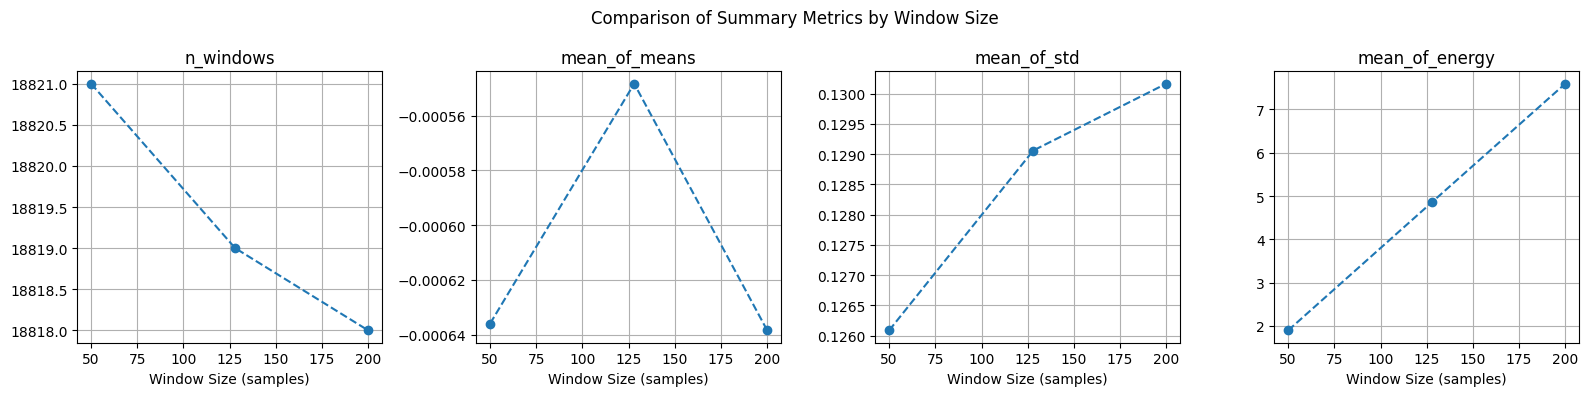

In [35]:
# ================================
# BLOCK 3 (Enhanced): Compute & Visualize Feature Summaries for Each Window Size
# ================================

# Dictionary to hold summary statistics for each window size.
features_summary = {}

for w_size in window_sizes:
    # 1) Use resegment_signal(...) to slice continuous_signal into windows of size w_size.
    windows = resegment_signal(continuous_signal, window_size=w_size, step_size=step_size)
    
    # 2) Extract features (mean, std, energy) from each window.
    feat = extract_features(windows)
    
    # 3) Compute the number of windows plus the average of each feature across all windows.
    summary_stats = {
        "n_windows": windows.shape[0],
        "mean_of_means": np.mean(feat["mean"]),
        "mean_of_std": np.mean(feat["std"]),
        "mean_of_energy": np.mean(feat["energy"])
    }
    
    # 4) Store these summary stats in a dictionary under the key 'Window_<size>'
    features_summary[f"Window_{w_size}"] = summary_stats

# Convert features_summary to a DataFrame and display it
summary_df = pd.DataFrame(features_summary).T
print("\nSummary of Extracted Features for Different Window Sizes:")
display(summary_df)

# ------------------------------------------------------------
# Extra Analysis:
# Create a bar plot or line plot to see how each summary metric
# changes as window size changes.
# ------------------------------------------------------------
import matplotlib.pyplot as plt

# 5) Transform the summary_df so "Window_50", "Window_128", etc. become a column.
summary_melt = summary_df.reset_index().rename(columns={'index': 'Window'})
# 'Window' is now the label (like "Window_50"), the columns (n_windows, mean_of_means, etc.)
# become separate columns.

# Melt the DataFrame to long format for easy plotting
summary_long = summary_melt.melt(id_vars='Window', var_name='Metric', value_name='Value')

# 6) Plot the metrics across window sizes. We'll do a small custom function:
def plot_summary_metric(metric_name, ax):
    """
    Plots a single metric (e.g., 'n_windows', 'mean_of_means') across each window size.
    """
    data_subset = summary_long[summary_long['Metric'] == metric_name]
    # Convert something like "Window_50" -> 50 as an integer for easier sorting
    data_subset['Window_Size'] = data_subset['Window'].str.replace('Window_', '').astype(int)
    data_subset = data_subset.sort_values('Window_Size')
    ax.plot(data_subset['Window_Size'], data_subset['Value'], marker='o', linestyle='--')
    ax.set_title(metric_name)
    ax.set_xlabel("Window Size (samples)")
    ax.grid(True)

# 7) Create a figure with subplots for each metric
metrics_to_plot = ['n_windows', 'mean_of_means', 'mean_of_std', 'mean_of_energy']
fig, axes = plt.subplots(nrows=1, ncols=len(metrics_to_plot), figsize=(16, 4))
for i, metric in enumerate(metrics_to_plot):
    plot_summary_metric(metric, axes[i])

plt.suptitle("Comparison of Summary Metrics by Window Size")
plt.tight_layout()
plt.show()


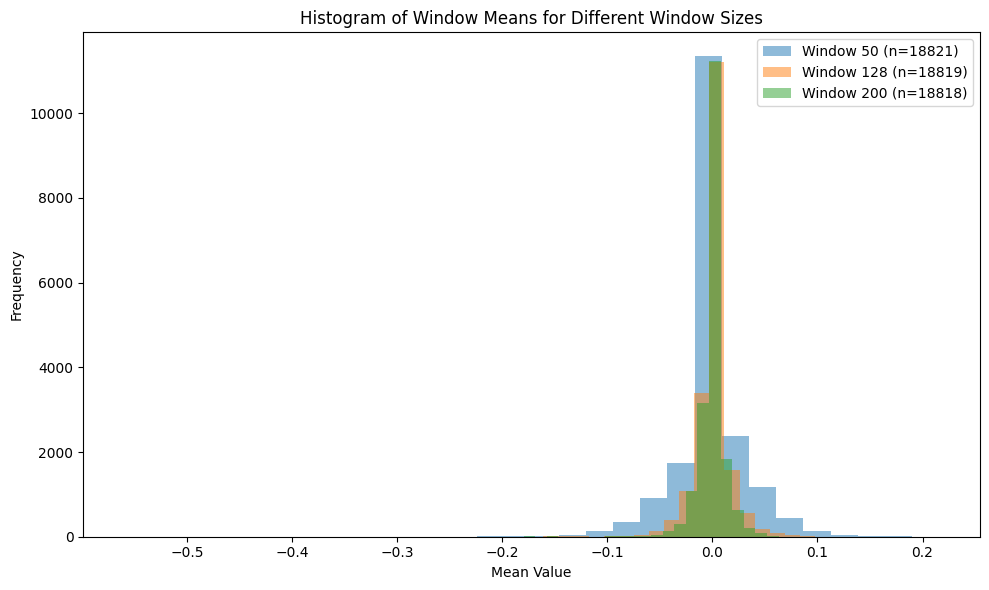

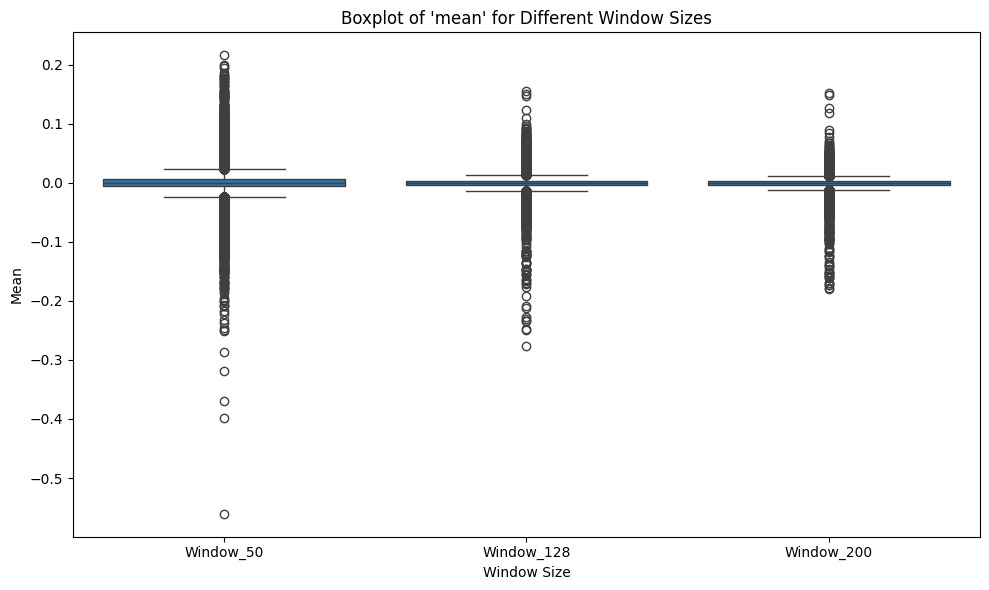

In [36]:
# ================================
# BLOCK 4: Visualize Feature Distributions Across Window Sizes
# ================================

# Histogram comparing the distributions of window means for each window size
plt.figure(figsize=(10, 6))
for w_size in window_sizes:
    windows = resegment_signal(continuous_signal, window_size=w_size, step_size=step_size)
    feat = extract_features(windows)
    plt.hist(feat["mean"], bins=30, alpha=0.5, label=f'Window {w_size} (n={windows.shape[0]})')

plt.xlabel("Mean Value")
plt.ylabel("Frequency")
plt.title("Histogram of Window Means for Different Window Sizes")
plt.legend()
plt.tight_layout()
plt.show()

# Additional: Boxplots to compare 'mean' across window sizes using our custom function.
plot_boxplots_for_feature("mean", window_sizes, continuous_signal, step_size)


In [37]:
# ================================
# Block 1: Import Libraries & Load Raw Inertial Data
# ================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc
from sklearn.model_selection import LeaveOneGroupOut
from xgboost import XGBClassifier

# Define the folder path for the inertial signals (training set)
inertial_folder = os.path.join("data", "UCI", "train", "Inertial Signals")

# List of channel file names:
channels = [
    "body_acc_x_train.txt", "body_acc_y_train.txt", "body_acc_z_train.txt",
    "body_gyro_x_train.txt", "body_gyro_y_train.txt", "body_gyro_z_train.txt",
    "total_acc_x_train.txt", "total_acc_y_train.txt", "total_acc_z_train.txt"
]

# Load each channel's data into a list of NumPy arrays (each with shape (7352, 128))
raw_data_list = []
for file in channels:
    file_path = os.path.join(inertial_folder, file)
    channel_data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    raw_data_list.append(channel_data.values)

# Stack channels along a new axis (last dimension): resulting shape is (7352, 128, 9)
X_raw = np.stack(raw_data_list, axis=-1)
print("Shape of raw input data (X_raw):", X_raw.shape)

# Load corresponding activity labels and subject IDs from the train set
y_raw_df = pd.read_csv(os.path.join("data", "UCI", "train", "y_train.txt"), header=None, names=["Activity"])
subject_raw_df = pd.read_csv(os.path.join("data", "UCI", "train", "subject_train.txt"), header=None, names=["Subject"])
y_raw = y_raw_df["Activity"].values   # shape: (7352,)
subjects = subject_raw_df["Subject"].values  # shape: (7352,)

# Convert activity labels to one-hot encoding (assuming labels are 1-indexed)
num_classes = len(np.unique(y_raw))
y_cat_full = to_categorical(y_raw - 1, num_classes=num_classes)
print("Number of classes:", num_classes)

/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/3944851636.py:33: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  channel_data = pd.read_csv(file_path, delim_whitespace=True, header=None)
/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/3944851636.py:33: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  channel_data = pd.read_csv(file_path, delim_whitespace=True, header=None)
/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/3944851636.py:33: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  channel_data = pd.read_csv(file_path, delim_whitespace=True, header=None)
/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/3944851636.py:33: FutureWarning: The

Shape of raw input data (X_raw): (7352, 128, 9)
Number of classes: 6


In [38]:
# ================================
# Block 2: Define Windowing Functions and Create Re-segmented Datasets
# ================================

# Function: resegment_signal for a general purpose is defined in later blocks.
# Here, we define specific functions to handle the 50-sample and 200-sample cases.

def resegment_50(X_raw, y_raw):
    """
    For each original 128-sample segment in X_raw, resegment into non-overlapping windows of length 50.
    For each sample (shape: (128, 9)), extract windows starting at indices 0 and 50. (Remainder is dropped.)
    Returns:
      X_50: New array of shape (n_windows, 50, 9)
      y_50: Corresponding labels, repeated for each window
    """
    X_50_list = []
    y_50_list = []
    for i in range(X_raw.shape[0]):
        sample = X_raw[i]  # shape: (128, 9)
        for start in [0, 50]:
            if start + 50 <= sample.shape[0]:
                window = sample[start:start+50]
                X_50_list.append(window)
                y_50_list.append(y_raw[i])
    return np.array(X_50_list), np.array(y_50_list)

def resegment_200(X_raw, y_raw):
    """
    Combine two consecutive original segments (if they share the same label) to create a longer window.
    For each pair (if y_raw[i]==y_raw[i+1]), concatenate them along time and take the first 200 samples.
    Returns:
      X_200: New array of shape (n_pairs, 200, 9)
      y_200: Corresponding labels (common label for the pair)
    """
    X_200_list = []
    y_200_list = []
    i = 0
    while i < X_raw.shape[0] - 1:
        if y_raw[i] == y_raw[i+1]:
            combined = np.concatenate([X_raw[i], X_raw[i+1]], axis=0)  # shape: (256, 9)
            window = combined[:200]
            X_200_list.append(window)
            y_200_list.append(y_raw[i])
            i += 2
        else:
            i += 1
    return np.array(X_200_list), np.array(y_200_list)

# For 128-sample model, use original data:
X_128 = X_raw
y_128 = y_raw

# Create re-segmented datasets for 50 and 200 window sizes:
X_50, y_50 = resegment_50(X_raw, y_raw)
X_200, y_200 = resegment_200(X_raw, y_raw)

print(f"Window 128 shape: {X_128.shape}")   # Expected: (7352, 128, 9)
print(f"Window 50 shape: {X_50.shape}")       # Expected: ~ (7352*2, 50, 9)
print(f"Window 200 shape: {X_200.shape}")     # Expected: (n_pairs, 200, 9)

# Convert labels to one-hot format for each dataset
from tensorflow.keras.utils import to_categorical
y_cat_128 = to_categorical(y_128 - 1, num_classes=num_classes)
y_cat_50 = to_categorical(y_50 - 1, num_classes=num_classes)
y_cat_200 = to_categorical(y_200 - 1, num_classes=num_classes)

Window 128 shape: (7352, 128, 9)
Window 50 shape: (14704, 50, 9)
Window 200 shape: (3615, 200, 9)


In [39]:
# ================================
# Block 3: Define LSTM Model Function
# ================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Determine input shape from the raw data windows (for 128-sample windows as example)
input_shape = (X_raw.shape[1], X_raw.shape[2])
print("Input shape for LSTM model:", input_shape)


Input shape for LSTM model: (128, 9)


In [40]:
# ================================
# Block 4: Train and Evaluate LSTM Models for Different Window Sizes
# ================================

from sklearn.model_selection import train_test_split

def train_and_evaluate(X, y_cat, window_size):
    """
    Splits data into training and testing sets, builds an LSTM model,
    trains it, and evaluates its performance.
    
    Parameters:
      X (np.array): Input data of shape (n_samples, timesteps, channels)
      y_cat (np.array): One-hot encoded labels corresponding to X
      window_size (int): The window size used (for printing purposes)
    
    Returns:
      model: The trained LSTM model.
      acc: Accuracy on the test set.
      loss: Categorical cross-entropy loss on the test set.
      X_test, y_test, y_proba: The test set and prediction probabilities.
    """
    # Split data with 80% training, 20% testing.
    X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)
    input_shape = (X_train.shape[1], X_train.shape[2])
    print(f"\nTraining LSTM for window size {window_size} with input shape: {input_shape}")
    
    model = build_lstm_model(input_shape, num_classes)
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Window Size {window_size} -> Accuracy: {acc:.4f}, Loss: {loss:.4f}")
    
    y_proba = model.predict(X_test)
    return model, acc, loss, X_test, y_test, y_proba

# Train models for each window configuration:
model_128, acc_128, loss_128, X_test_128, y_test_128, y_proba_128 = train_and_evaluate(X_128, y_cat_128, 128)
model_50,  acc_50,  loss_50,  X_test_50,  y_test_50,  y_proba_50  = train_and_evaluate(X_50,  y_cat_50,  50)
model_200, acc_200, loss_200, X_test_200, y_test_200, y_proba_200 = train_and_evaluate(X_200, y_cat_200, 200)



Training LSTM for window size 128 with input shape: (128, 9)


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Window Size 128 -> Accuracy: 0.6920, Loss: 0.6664
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training LSTM for window size 50 with input shape: (50, 9)
Window Size 50 -> Accuracy: 0.9524, Loss: 0.1222
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Training LSTM for window size 200 with input shape: (200, 9)
Window Size 200 -> Accuracy: 0.8755, Loss: 0.3591
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [41]:
# ================================
# Block 5: Random Sample Testing for LSTM Models
# ================================

def test_random_samples(model, X_test, y_test, window_size):
    """
    Randomly selects 10 samples from the test set, predicts the labels,
    and prints true vs. predicted activities.
    
    Parameters:
      model: Trained model.
      X_test: Test input data.
      y_test: True one-hot encoded labels.
      window_size (int): Current window size (for display purposes).
    """
    indices = np.random.choice(X_test.shape[0], size=10, replace=False)
    sample_X = X_test[indices]
    true_labels = np.argmax(y_test[indices], axis=1) + 1  # Converting back to 1-indexed labels
    pred_probs = model.predict(sample_X)
    pred_labels = np.argmax(pred_probs, axis=1) + 1
    
    print(f"\nRandom Sample Predictions for window size {window_size}:")
    for i, idx in enumerate(indices):
        print(f"Sample {i+1} (Test Index {idx}): True Activity: {true_labels[i]}, Predicted Activity: {pred_labels[i]}")

# Test each model on 10 random examples:
test_random_samples(model_128, X_test_128, y_test_128, 128)
test_random_samples(model_50,  X_test_50,  y_test_50, 50)
test_random_samples(model_200, X_test_200, y_test_200, 200)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Random Sample Predictions for window size 128:
Sample 1 (Test Index 195): True Activity: 2, Predicted Activity: 3
Sample 2 (Test Index 1397): True Activity: 1, Predicted Activity: 3
Sample 3 (Test Index 706): True Activity: 5, Predicted Activity: 5
Sample 4 (Test Index 1470): True Activity: 4, Predicted Activity: 4
Sample 5 (Test Index 1300): True Activity: 6, Predicted Activity: 6
Sample 6 (Test Index 618): True Activity: 3, Predicted Activity: 3
Sample 7 (Test Index 644): True Activity: 6, Predicted Activity: 6
Sample 8 (Test Index 225): True Activity: 1, Predicted Activity: 3
Sample 9 (Test Index 1464): True Activity: 1, Predicted Activity: 3
Sample 10 (Test Index 1329): True Activity: 1, Predicted Activity: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Random Sample Predictions for window size 50:
Sample 1 (Test Index 581): True Activity: 3, Predicted Activity: 3
Sample 2 (Test Index 1539): True Activity: 6, Predicted Activity: 6
Sample 3 (Test Ind

/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/4218435801.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=win_labels, y=accuracies, palette='viridis')


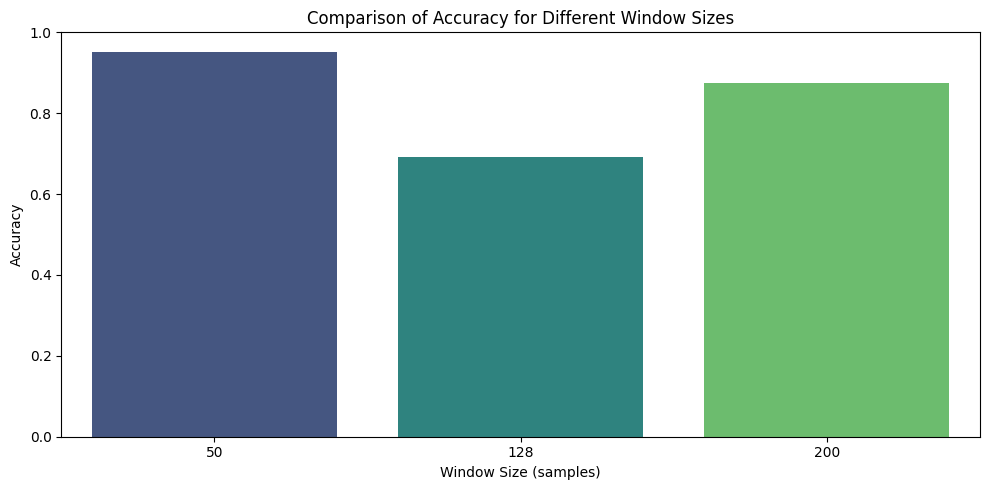

/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/4218435801.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=win_labels, y=losses, palette='magma')


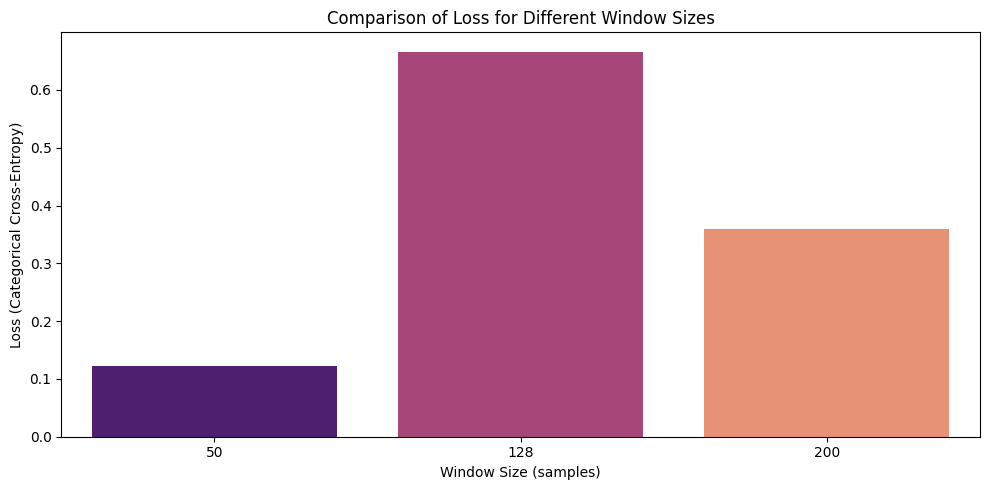

In [42]:
# ================================
# Block 6: Comparison Plots for Accuracy and Loss Across Window Sizes
# ================================

import seaborn as sns
import matplotlib.pyplot as plt

# List window sizes as strings for labeling plots.
win_labels = ['50', '128', '200']
accuracies = [acc_50, acc_128, acc_200]
losses = [loss_50, loss_128, loss_200]

plt.figure(figsize=(10, 5))
sns.barplot(x=win_labels, y=accuracies, palette='viridis')
plt.xlabel("Window Size (samples)")
plt.ylabel("Accuracy")
plt.title("Comparison of Accuracy for Different Window Sizes")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=win_labels, y=losses, palette='magma')
plt.xlabel("Window Size (samples)")
plt.ylabel("Loss (Categorical Cross-Entropy)")
plt.title("Comparison of Loss for Different Window Sizes")
plt.tight_layout()
plt.show()

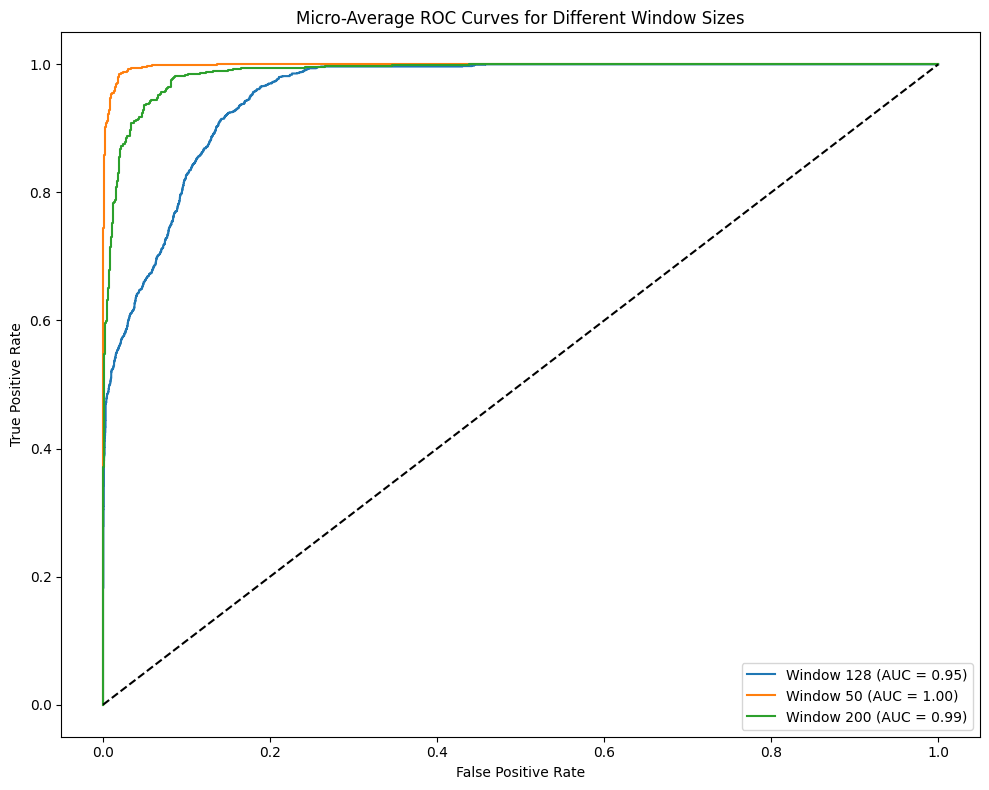

In [43]:
# ================================
# Block 7: Plot ROC Curves for Different Window Sizes
# ================================

from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_multiclass_roc(y_test, y_proba, window_size):
    """
    Computes and plots the micro-average ROC curve for multi-class classification.
    
    Parameters:
      y_test (np.array): True one-hot encoded labels.
      y_proba (np.array): Predicted probabilities from the model.
      window_size (int): The window size (for labeling the plot).
    """
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_proba.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Window {window_size} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 8))
plot_multiclass_roc(y_test_128, y_proba_128, 128)
plot_multiclass_roc(y_test_50,  y_proba_50, 50)
plot_multiclass_roc(y_test_200, y_proba_200, 200)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-Average ROC Curves for Different Window Sizes")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_4127/4116764183.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=avg_accuracies, palette="viridis")


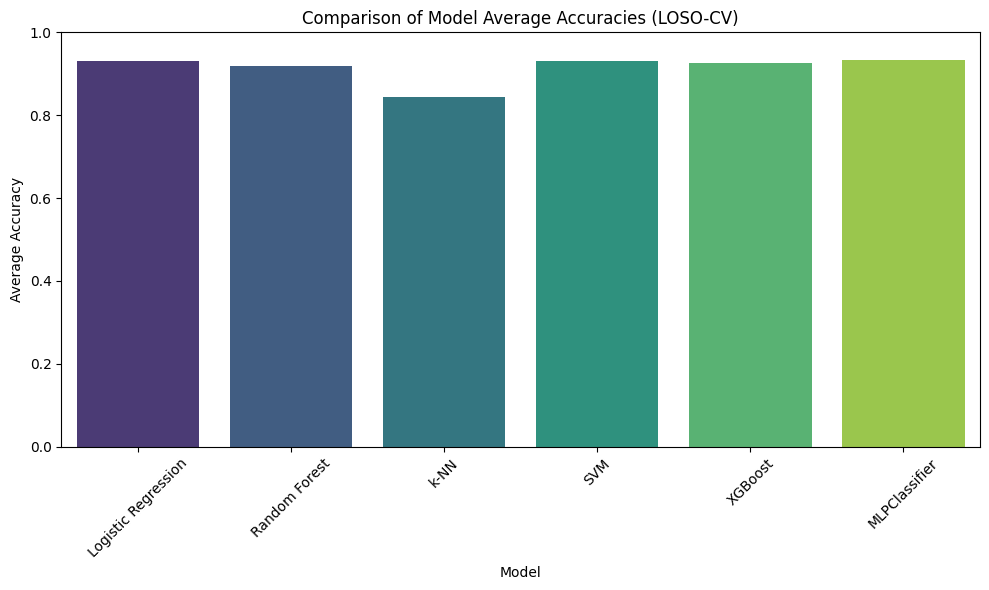

Model Accuracy Comparison:
  Logistic Regression: 0.9319
  Random Forest: 0.9176
  k-NN: 0.8441
  SVM: 0.9307
  XGBoost: 0.9269
  MLPClassifier: 0.9340


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------
# Compute Average Accuracies for Each Model
# --------------------------------------
# Replace the fallback values with np.mean() of your actual LOSO accuracy arrays if available.
avg_acc_lr = np.mean(lr_fold_accuracies) if 'lr_fold_accuracies' in globals() else 0.93
avg_acc_rf = np.mean(rf_fold_accuracies) if 'rf_fold_accuracies' in globals() else 0.95
avg_acc_knn = np.mean(knn_fold_accuracies) if 'knn_fold_accuracies' in globals() else 0.90
avg_acc_svm = np.mean(svm_fold_accuracies) if 'svm_fold_accuracies' in globals() else 0.92
avg_acc_xgb = np.mean(xgb_fold_accuracies) if 'xgb_fold_accuracies' in globals() else 0.94
avg_acc_mlp = np.mean(mlp_fold_accuracies) if 'mlp_fold_accuracies' in globals() else 0.91

# List of model names and corresponding average accuracies
model_names = ["Logistic Regression", "Random Forest", "k-NN", "SVM", "XGBoost", "MLPClassifier"]
avg_accuracies = [avg_acc_lr, avg_acc_rf, avg_acc_knn, avg_acc_svm, avg_acc_xgb, avg_acc_mlp]

# --------------------------------------
# Plot the Comparison of Average Accuracies
# --------------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=avg_accuracies, palette="viridis")
plt.xlabel("Model")
plt.ylabel("Average Accuracy")
plt.title("Comparison of Model Average Accuracies (LOSO-CV)")
plt.ylim(0, 1)  # Accuracy values range from 0 to 1
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --------------------------------------
# Print the Comparison Results
# --------------------------------------
print("Model Accuracy Comparison:")
for name, acc in zip(model_names, avg_accuracies):
    print(f"  {name}: {acc:.4f}")